In [ ]:
import os
import sys
import pandas as pd
import argparse
import warnings
from utils import *
from torch import nn
import copy
from tqdm import tqdm
import random 
from data_loader import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import numpy as np
from http import HTTPStatus
import dashscope
from xgboost import XGBRegressor
from dashscope import Generation
import json
# import openai
from deepseek import DeepSeekClient
import os
from train import *
from model import GurobiPowerScheduler_milp
import pickle
from openai import OpenAI
warnings.filterwarnings("ignore")
#set deepseek and openai API keys


In [3]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='seq2seq')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=1e-3)
parser_train.add_argument('--patience', type=int, default=5)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_ft_lr', type=float, default=1e-6)
parser_train.add_argument('--e2e_lr', type=float, default=1e-7)#1e-7
parser_train.add_argument('--ft_lr', type=float, default=1e-4)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e1)
parser_train.add_argument('--epsion_l', type=float, default=1e1)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])


parser_train.add_argument('--N_g', type=int, default=3)
parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=25)
parser_train.add_argument('--x_max', type=int, default=[1500,1800,2000])
parser_train.add_argument('--x_min', type=int, default=[200,300,400])
parser_train.add_argument('--z_pos_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_neg_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=[800,800,500])
parser_train.add_argument('--r_pos', type=int, default=[800,800,500])
parser_train.add_argument('--alpha', type=list, default=[0.03 for i in range(24)]+[0.028 for i in range(24)]+[0.032 for i in range(24)])
parser_train.add_argument('--alpha_pos', type=list, default=[0.02 for i in range(24)]+[0.018 for i in range(24)]+[0.022 for i in range(24)])
parser_train.add_argument('--alpha_neg', type=list, default=[0.01 for i in range(24)]+[0.009 for i in range(24)]+[0.011 for i in range(24)])

parser_train.add_argument('--rho_z_pos', type=list, default=[0.05 for i in range(24)]+[0.045 for i in range(24)]+[0.055 for i in range(24)])
parser_train.add_argument('--rho_z_neg', type=list, default=[0.01 for i in range(24)]+[0.008 for i in range(24)]+[0.012 for i in range(24)])

parser_train.add_argument('--rho_r_pos', type=list, default=[0.1 for i in range(24)])
parser_train.add_argument('--rho_r_neg', type=list, default=[0.05 for i in range(24)])
parser_train.add_argument('--min_up_time', type=int, default=6)
parser_train.add_argument('--price_ratio_large', type=float, default=2.5)
parser_train.add_argument('--price_ratio_small', type=float, default=0.8)
parser_train.add_argument('--flag_dynamic_price', type=bool, default=False)
parser_train.add_argument('--flag_dynamic_mode', type=int, default=2)
parser_train.add_argument('--upper_quantiles', type=float, default=0.95)
parser_train.add_argument('--lower_quantiles', type=float, default=0.05)
parser_train.add_argument('--epsion', type=float, default=1)
parser_train.add_argument('--LLM_type', type=str, default='Deepseek')
args = parser_train.parse_args(args=[])

In [4]:
train_load_data,train_load_loader=get_load_data(args,flag='train')
val_load_data,val_load_loader=get_load_data(args,flag='val')
test_load_data,test_load_loader=get_load_data(args,flag='test')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

X_test=train_load_data.inverse_transform_X(test_load_data.X)
X_train=train_load_data.inverse_transform_X(train_load_data.X)
X_val=train_load_data.inverse_transform_X(val_load_data.X)

../Data/GEF_data/data(3 year).csv
(26113, 219)


../Data/GEF_data/data(3 year).csv
(26113, 219)
../Data/GEF_data/data(3 year).csv
(26113, 219)


In [5]:
from utils import *
combined_train_data,combined_train_loader,combined_val_data,combined_val_loader,combined_test_data,combined_test_loader,combined_fine_tune_data,combined_fine_tune_loader = obtain_price(args,train_load_data,val_load_data,test_load_data)
data_iter = iter(combined_test_loader)
input_load_test, labels_load_test, alpha_test, alpha_z_test, rho_z_test, rho_r_test = next(data_iter)

alpha_sample=alpha_test[0,:].detach().cpu().numpy()
alpha_z_sample=alpha_z_test[0,:].detach().cpu().numpy()
rho_z_sample=rho_z_test[0,:].detach().cpu().numpy()
rho_r_sample=rho_r_test[0,:].detach().cpu().numpy()

optimization_module = GurobiPowerScheduler_milp(args, alpha_sample, alpha_z_sample, rho_z_sample, rho_r_sample)

Test data is not shuffled
Test data is not shuffled
[1500. 1800. 2000.]
[200. 300. 400.]


In [6]:
input_size=train_load_data.X.shape[-1]
output_size=24
set_seed(42)

layer_sizes=[128,128,128]
model_load=ANN(input_size=input_size, layer_sizes=layer_sizes, output_size=output_size).to(device)
train(args, model_load, train_load_loader, val_load_loader,dir_best_model='../Model/best_ann_load.pt')

Using device: cuda:0


Epoch [1/1000] Train Loss: 0.0588 Val Loss: 0.0193
Epoch [2/1000] Train Loss: 0.0090 Val Loss: 0.0075
Epoch [3/1000] Train Loss: 0.0059 Val Loss: 0.0069
Epoch [4/1000] Train Loss: 0.0054 Val Loss: 0.0066
Epoch [5/1000] Train Loss: 0.0053 Val Loss: 0.0064
Epoch [6/1000] Train Loss: 0.0049 Val Loss: 0.0060
Epoch [7/1000] Train Loss: 0.0049 Val Loss: 0.0057
Epoch [8/1000] Train Loss: 0.0052 Val Loss: 0.0055
Epoch [9/1000] Train Loss: 0.0043 Val Loss: 0.0052
Epoch [10/1000] Train Loss: 0.0041 Val Loss: 0.0048
Epoch [11/1000] Train Loss: 0.0038 Val Loss: 0.0046
Epoch [12/1000] Train Loss: 0.0037 Val Loss: 0.0043
Epoch [13/1000] Train Loss: 0.0034 Val Loss: 0.0041
Epoch [14/1000] Train Loss: 0.0036 Val Loss: 0.0038
Epoch [15/1000] Train Loss: 0.0034 Val Loss: 0.0036
Epoch [16/1000] Train Loss: 0.0028 Val Loss: 0.0038
Epoch [17/1000] Train Loss: 0.0029 Val Loss: 0.0035
Epoch [18/1000] Train Loss: 0.0029 Val Loss: 0.0032
Epoch [19/1000] Train Loss: 0.0026 Val Loss: 0.0029
Epoch [20/1000] Train

In [7]:
cost_calculation=False
if 'cost_lists_milp.pkl' not in os.listdir():
    cost_calculation=True
else:
    with open('cost_lists_milp.pkl', 'rb') as f:
        cost_result=pickle.load(f)
        cost_list_train=cost_result['cost_list_train']
        cost_list_train_ideal=cost_result['cost_list_train_ideal']
        cost_list_val=cost_result['cost_list_val']
        cost_list_val_ideal=cost_result['cost_list_val_ideal']
        cost_list_test=cost_result['cost_list_test']
        cost_list_ideal=cost_result['cost_list_test_ideal']

In [8]:
test_input=torch.tensor(test_load_data.X).to(device).float()
test_pred_nor=model_load(test_input).detach().cpu().numpy()
test_pred = train_load_data.inverse_transform(test_pred_nor)
test_actual_nor=test_load_data.y
test_actual = train_load_data.inverse_transform(test_actual_nor)

print(MAE(test_pred,test_actual),RMSE(test_pred,test_actual),MAPE(test_pred,test_actual))

if cost_calculation:
    cost_list_test=[]
    cost_list_ideal=[]
    for i in range(len(test_pred)):
        forecasts=test_pred[i,:]
        actual=test_actual[i,:]
        _,_,costs_org=optimization_module.forward(forecasts,actual)
        _,_,costs_ideal=optimization_module.forward(actual,actual)
        cost_list_test.append(costs_org)
        cost_list_ideal.append(costs_ideal)


val_input=torch.tensor(val_load_data.X).to(device).float()
val_pred_nor=model_load(val_input).detach().cpu().numpy()
val_pred = train_load_data.inverse_transform(val_pred_nor)
val_actual_nor=val_load_data.y#.reshape(-1,1)
val_actual = train_load_data.inverse_transform(val_actual_nor)

print(MAE(val_pred,val_actual),RMSE(val_pred,val_actual),MAPE(val_pred,val_actual))

if cost_calculation:
    cost_list_val_ideal=[]
    cost_list_val=[]
    for i in range(len(val_pred)):
        forecasts=val_pred[i,:]
        actual=val_actual[i,:]
        _,_,costs_org=optimization_module.forward(forecasts,actual)
        _,_,costs_ideal=optimization_module.forward(actual,actual)
        cost_list_val.append(costs_org)
        cost_list_val_ideal.append(costs_ideal)

train_input=torch.tensor(train_load_data.X).to(device).float()
train_pred_nor=model_load(train_input).detach().cpu().numpy()
train_pred = train_load_data.inverse_transform(train_pred_nor)
train_actual_nor=train_load_data.y#.reshape(-1,1)
train_actual = train_load_data.inverse_transform(train_actual_nor)
print(MAE(train_pred,train_actual),RMSE(train_pred,train_actual),MAPE(train_pred,train_actual))
if cost_calculation:
    cost_list_train_ideal=[]
    cost_list_train=[]
    for i in range(len(train_pred)):
        forecasts=train_pred[i,:]
        actual=train_actual[i,:]
        _,_,costs_org=optimization_module.forward(forecasts,actual)
        _,_,costs_ideal=optimization_module.forward(actual,actual)
        cost_list_train.append(costs_org)
        cost_list_train_ideal.append(costs_ideal)
    #save cost_list_train，cost_list_train_ideal，cost_list_val，cost_list_val_ideal，cost_list_test，cost_list_test_ideal into a pkl

108.93030977797234 139.44284533957995 0.029723884245756324
93.48481050557758 131.1995755421263 0.027242015189285804
86.26146852859128 118.6684663545049 0.025493223048933752


In [9]:
from E2E import E2E_test_ideal,E2E_test,E2E_train

In [10]:
from model import *
from E2E import *

In [ ]:
cost_list_test_insert=[cost_list_test[i]-cost_list_ideal[i] for i in range(len(cost_list_test))]
actual_load_test_insert=test_actual_nor
forecasts_load_test_insert=test_pred_nor

cost_list_train_insert=[cost_list_train[i]-cost_list_train_ideal[i] for i in range(len(cost_list_train))]
actual_load_train_insert=train_actual_nor
forecasts_load_train_insert=train_pred_nor

cost_list_val_insert=[cost_list_val[i]-cost_list_val_ideal[i] for i in range(len(cost_list_val))]
actual_load_val_insert=val_actual_nor
forecasts_load_val_insert=val_pred_nor

db_train = CurveDictDB()
cur_id_start = max(db_train.data.keys(), default=0) + 1
for i, (cost, load, fine_tuned_load, actual_load) in enumerate(zip(cost_list_train_insert, forecasts_load_train_insert,forecasts_load_train_insert, actual_load_train_insert)):
    record = {
        'id': cur_id_start + i,
        'flag': 0,
        'prompt': '',
        'load': load,
        'fine_tuned_load': fine_tuned_load,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0,
    }
    db_train.insert(record)

db_val = CurveDictDB()
cur_id_start_val = max(db_val.data.keys(), default=0) + 1
for i, (cost, load, fine_tuned_load, actual_load) in enumerate(zip(cost_list_val_insert, forecasts_load_val_insert, forecasts_load_val_insert, actual_load_val_insert)):
    record = {
        'id': cur_id_start_val + i,
        'flag': 0,
        'prompt': '',
        'load': load,
        'fine_tuned_load': fine_tuned_load,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0,
    }
    db_val.insert(record)


In [12]:
def generate_prompt_sys(args,data):
    # Return English prompt
    prompt = (
        f"You are a power dispatch expert. There are {args.N_g} generating units:\n"
        f"Unit 1: {args.x_min}~{args.x_max} MW, "
        f"Unit 2: {args.x_min}~{args.x_max} MW, "
        f"Unit 3: {args.x_min}~{args.x_max} MW.\n"
        f"Unit 1 generation cost: {args.alpha[0:args.T]}*x RMB/kWh, "
        f"Unit 2 generation cost: {args.alpha[args.T:2*args.T]}*x RMB/kWh, "
        f"Unit 3 generation cost: {args.alpha[args.T*2:args.T*3]}*x RMB/kWh.\n"
        f"Unit 1 positive reserve limit: {args.rho_z_pos[0:args.T]} RMB/kWh, "
        f"Unit 1 negative reserve limit: {args.rho_z_neg[0:args.T]} RMB/kWh.\n"
        f"Unit 2 positive reserve limit: {args.rho_z_pos[args.T:2*args.T]} RMB/kWh, "
        f"Unit 2 negative reserve limit: {args.rho_z_neg[args.T:2*args.T]} RMB/kWh.\n"
        f"Unit 3 positive reserve limit: {args.rho_z_pos[args.T*2:args.T*3]} RMB/kWh, "
        f"Unit 3 negative reserve limit: {args.rho_z_neg[args.T*2:args.T*3]} RMB/kWh.\n"  
        f"The minimum time of units being online is {args.min_up_time} hours.\n" 
       # f"Predicted load: {data['load']}\n"
       # "Decision making task is to output the optimized generation schedule for the three units for each hour, "
       # "ensuring all constraints are met and the power purchase cost is minimized."
       # "Hint: if positive reserve price larger than negative reserve, generates more in day ahead can avoid high positive reserve cost in real time."
       # "Make significant adjustments to the load curve to reduce costs. Do not be afraid to deviate from the original load pattern if it leads to cost savings.\n"
    )
    
    return prompt

In [13]:

output_require_prompt = """Please learn from the few-shot record and derived a combined strategy to adjust the original load curve.
    You can only change several time points, and each point can only be changed within ±10% of the original value.
    Output a Python function named "adjustment_strategy" that implements the optimization strategy. The function should take the original load curve as input and return a list of 24 delta values (changes to apply).

    Requirements:
    1. Define a function: def adjustment_strategy(original_load: list) -> list:
    2. The function must return a list of 24 numbers (deltas)
    3. Use only basic Python operations (no external libraries)
    4. Include comments explaining your strategy
    5. Example:
        def adjustment_strategy(original_load):
            deltas = []
            for i, load_val in enumerate(original_load):
                if 8 <= i < 18:
                    deltas.append(load_val * 0.05) 
                if 20 <= i <22:
                    deltas.append(-load_val * 0.03) 
            return deltas
    """
 

### main

In [ ]:
def few_shot_prompt_generate(args, similar_days, max_strategies=10, max_attempts=5):  
    """  
    Generate few-shot prompts for small-scale adjustment strategies  
    Each adjustment modifies no more than 5 time points, gradually building a strategy library  
      
    Parameters:  
        args: Model parameters  
        db: Database connection object  
        similar_days: List of similar day data  
        max_strategies: Maximum number of valid strategies  
        max_attempts: Maximum number of attempts  
          
    Returns:  
        tuple: (Strategy history string, List of valid strategies)  
    """  
    # Get average load of similar days
    similar_day_load_nor = np.mean([day['load'] for极 day in similar_days], axis=0)  
    similar_day_actual_nor = np.mean([day['actual_load'] for day in similar_days], axis=0)  
      
    # Calculate original cost  
    similar_day_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_load_nor).reshape(1,-1))[0]  
    similar_day_actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_actual_nor).reshape(1,-1))[0]  
    _, _, original_cost = optimization_module.forward(similar_day_load_numpy, similar_day_actual_load_numpy)  
    original_cost = original_cost.item()  
      
    # Strategy generation prompt template  
    sim_data = {"load": similar_day_load_nor}  
    system_prompt = generate_prompt_sys(args, sim_data)  
    higher_flag = "higher" if sum(np.array(similar_day_load_nor) - np.array(similar_day_actual_nor)) > 0 else "lower"  
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"  
    system_prompt += f"""\n The maximum load occurs at {int(np.argmax(similar_day_load_nor))} hour, and the minimum load occurs at {int(np.argmin(similar_day_load_nor))} hour.\n\n"""  
    system_prompt += f"""  
    You have two approaches to reduce cost:  

    1. Compare the actual value and forecast of the similar day, try to learn some error reduction strategies. In this case, the similar day forecast is {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.  
    2. Compare the future positive and negative reserve prices.  
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.  
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.  
    """  

    output_require_prompt = f"""  
    You are an expert in electricity load curve fine-tuning. Your task is to generate Python functions that implement small-scale optimization strategies for daily electricity load curves.  

    Requirements:  
    1. Generate exactly 10 distinct Python functions named "strategy_1", "strategy_2", "strategy_3", "strategy_4", "strategy_5", "strategy_6", "strategy_7", "strategy_8", "strategy_9", and "strategy_10".  
    2. The strategy should focus on a *different* part of the load curve, avoiding concentrating all changes in same time intervals.  
    2. Each function must:  
       - Take a single argument: the original load curve (list of 24 hourly values)  
       - Return a list of 24 numbers (deltas) representing adjustments to each hour  
    3. Each strategy must:  
       - Adjust no more than 5 time points (hours)  
       - Target adjacent hours (e.g., 7pm to 9pm)  
       - Keep adjustments within ±10% of the original value at each hour  
       - Try to be distinct from other strategies  
    4. Use only basic Python operations (no external libraries)  
    5. Include comments explaining:  
       - Which specific hours are targeted  
       - Why this strategy might reduce electricity costs  
    6. Example strategies:  

    Example 1: Reduce evening peak  
    def strategy_1(original_load):  
        # Focus: Reduce peak at 18:00 and 19:00 only  
        deltas = [0] * 24  
        # Only adjust hours 18 and 19  
        deltas[18] = -original_load[18] * 0.02  # Reduce by 2%  
        deltas[19] = -original_load[19] * 0.02  # Reduce by 2%  
        return deltas  

    Example 2: Shift load from afternoon to late afternoon  
    def strategy_2(original_load):  
        # Focus: Shift load from 14:00 to 15:00  
        deltas = [0] * 24  
        # Only adjust hours 14 and 15  
        deltas[14] = original_load[14] * 0.015  # Reduce at 14:00  
        deltas[15] = original_load[14] * 0.015   # Increase at 15:00  
        return deltas  

    Example 3: Increase off-peak consumption  
    def strategy_3(original_load):  
        # Focus: Slightly increase off-peak at 2:00 and 3:00  
        deltas = [0] * 24  
        # Only adjust hours 2 and 3  
        deltas[2] = original_load[2] * 0.03  # Increase by 3%  
        deltas[3] = original_load[3] * 0.03  # Increase by 3%  
        return deltas  

    Example 4: Flatten morning peak  
    def strategy_4(original_load):  
        # Focus: Reduce morning peak at 8:00 and shift to 9:00  
        deltas = [0] * 24  
        # Only adjust hours 8 and 9  
        deltas[8] = -original_load[8] * 0.05  # Reduce at 8:00  
        deltas[9] = original_load[8] * 0.05   # Increase at 9:00  
        return deltas  

    Example 5: Smooth transition between peak and off-peak  
    def strategy_5(original_load):  
        # Focus: Smooth transition from evening to night (20:00-21:00)  
        deltas = [0] * 24  
        # Only adjust hours 20 and 21  
        deltas[20] = -original_load[20] * 0.02  # Reduce at 20:00  
        deltas[21] = -original_load[20] * 0.02   # Increase at 21:00  
        return deltas  
    """  
      
    # Store valid strategies  
    valid_strategies = []  
    strategy_history = ""  
    attempt_count = 0  
    full_prompt = ''  
    while (len(valid_strategies) < max_strategies and attempt_count < max_attempts) or (len(valid_strategies) < int(max_strategies)/2 and attempt_count < 10):  
        attempt_count += 1  
        print(f"Strategy generation attempt #{attempt_count} (Current valid strategies: {len(valid_strategies)}/{max_strategies})")  
        if valid_strategies != []:  
            history_snippet = 'Here are some previously discovered effective small-scale adjustment strategies:\n, you can modify these strategies or generate new ones.\n'  
            for i in range(len(valid_strategies)):  
                history_snippet += (f"Strategy {i+1}:\n{valid_strategies[i]['code']}\n\n")  
        else:  
            history_snippet = "No previously discovered effective small-scale adjustment strategies."  
        if attempt_count >= int(max_attempts)/2:  
            print('Providing actual load values')  
            full_prompt += (f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"  
                            f"HISTORICAL CONTEXT:\n{history_snippet}\极\n"  
                            f"This is your FINAL attempt for this similar day. The actual load is {similar_day_actual_nor}. Use all your knowledge and experience to produce the best possible optimized load curves.\n\n"  
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")  
        else:  
            full_prompt += (  
                            f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"  
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"  
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")  
        try:  
            # Extract strategy code  
            if args.LLM_type == 'Qwen':  
                response = Generation.call(  
                model="qwen-plus",  
                messages=[  
                    {"role": "system", "content": full_prompt},  
                ],  
                parameters={  
                    "temperature": 0.3,  
                    "max_tokens": 2048,  
                    "top_k": 20  
                }  
                )  
                raw_text = response.output.text.strip()  
                func_code = extract_pure_code(raw_text)  
            elif args.LLM_type == 'ChatGPT':  
                client = OpenAI(  
                    base_url='https://api.openai-proxy.org/v1',  
                    api_key=OPENAI_API_KEY  
                )  
                response = client.chat.completions.create(  
                    messages=[  
                           {"role": "system", "content": full_prompt},  
                    ],  
                    model="gpt-4o-mini",  
                    temperature=0.3,  
                    max_tokens=2048,  
                )  
                raw_text = response.choices[0].message.content.strip()  
                func_code = extract_pure_code(raw_text)  
              
            elif args.LLM_type == 'Deepseek':  
                client = OpenAI(api_key=DEEPSEEK_API_KEY,  
                base_url="https://api.deepseek.com")  
                response = client.chat.completions.create(  
                    model="deepseek-chat",  
                    messages=[  
                        {"role": "system", "content": full_prompt},  
                    ],  
                    temperature=0.3,  
                    max_tokens=2048,  
                    stream=False,  
                )  
                raw_text = response.choices[0].message.content.strip()  
                func_code = extract_pure_code(raw_text)  
            
            # Evaluate all strategy functions (separately)  
            strategy_results = evaluate_individual_strategies(  
                func_code,   
                similar_day_load_nor.tolist(),  
                max_change_percent=0.05  
            )  
              
            if not strategy_results:  
                print("No valid strategy functions generated")  
                continue  
                  
            for name, strategy in strategy_results.items():  
                try:  
                    # Apply strategy to similar day data  
                    adjusted_curve = strategy['adjusted_curve']  
                    adjusted_numpy =  train_load_data.scaler_y.inverse_transform(np.array(adjusted_curve).reshape(1,-1))[0]  
                      
                    # Calculate strategy cost  
                    _, _, strategy_cost = optimization_module.forward(adjusted_numpy, similar_day_actual_load_numpy)  
                    strategy_cost = strategy_cost.item()  
                      
                    # Check if cost is reduced  
                    if strategy_cost < original_cost - 1:  
                        # Check number of adjusted points  
                        adjusted_hours = sum(1 for delta in strategy['delta_curve'] if abs(delta) > 1e-5)  
                        if adjusted_hours <= 5:  # Ensure only 5 or fewer time points are adjusted  
                            valid_strategies.append({  
                                'name': 'Strategy ' + str(len(valid_strategies)+1),  
                                'code': strategy['func_code'],  
                                'cost_reduction': original_cost - strategy_cost,  
                                'final_cost': strategy_cost,  
                                'original_cost': original_cost,  
                                'original_load' : similar_day_load_nor.tolist(),  
                                'actual_load': similar_day_actual_nor.tolist(),  
                                'adjusted_curve': adjusted_curve,  
                                'adjusted_hours': adjusted_hours  
                            })  
                              
                            # Add to history  
                            strategy_history += (  
                                f"Strategy {name} reduced cost on similar day: {original_cost - strategy_cost:.2f}\n"  
                                f"Adjusted time points: {adjusted_hours} hours\n"  
                                f"Code:\n{strategy['func_code']}\n\n"  
                            )  
                              
                            print(f"Discovered valid strategy {name}, cost {strategy_cost:.2f}, original cost {original_cost:.2f}, (reduction {original_cost - strategy_cost:.2f})")  
                              
                            # Exit early if max strategies reached  
                            if len(valid_strategies) >= max_strategies:  
                                break  
                except Exception as e:  
                    print(f"Error evaluating strategy {name}: {str(e)}")  
          
        except Exception as e:  
            print(f"Strategy generation exception: {str(e)}")  
      
    # Add empty strategy if no valid strategies found  
    if not valid_strategies:  
        strategy_history = "No valid small-scale adjustment strategies found"  
      
    return strategy_history, valid_strategies  

def remove_comments(code_str):  
    # Remove multi-line comments (including triple quotes)  
    code_str = re.sub(r'("""[\s\S]*?"""|\'\'\'[\s\S]*?\'\'\')', '', code_str)  
    # Remove single-line comments  
    code_str = re.sub(r'#.*', '', code_str)  
    # Remove extra blank lines  
    code_str = re.sub(r'\n\s*\n', '\n', code_str)  
    return code_str

Processing inquiry 1/29
Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-26


Found 3 similar days for inquiry 0
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_5，成本 2437.14, 原始成本 2438.86, (降低 1.72)
发现有效策略 strategy_10，成本 2433.90, 原始成本 2438.86, (降低 4.96)
策略生成尝试 #2 (当前有效策略: 2/20)
发现有效策略 strategy_1，成本 2431.28, 原始成本 2438.86, (降低 7.58)
发现有效策略 strategy_5，成本 2437.14, 原始成本 2438.86, (降低 1.72)
发现有效策略 strategy_7，成本 2435.38, 原始成本 2438.86, (降低 3.49)
发现有效策略 strategy_10，成本 2433.90, 原始成本 2438.86, (降低 4.96)
策略生成尝试 #3 (当前有效策略: 6/20)
give actual value
发现有效策略 strategy_1，成本 2431.28, 原始成本 2438.86, (降低 7.58)
发现有效策略 strategy_3，成本 2436.54, 原始成本 2438.86, (降低 2.33)
发现有效策略 strategy_5，成本 2437.14, 原始成本 2438.86, (降低 1.72)
发现有效策略 strategy_10，成本 2433.90, 原始成本 2438.86, (降低 4.96)
策略生成尝试 #4 (当前有效策略: 10/20)
give actual value
发现有效策略 strategy_1，成本 2431.28, 原始成本 2438.86, (降低 7.58)
发现有效策略 strategy_3，成本 2436.54, 原始成本 2438.86, (降低 2.33)
发现有效策略 strategy_5，成本 2437.14, 原始成本 2438.86, (降低 1.72)
发现有效策略 strategy_6，成本 2433.90, 原始成本 2438.86, (降低 4.96)
发现有效策略 strategy_

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


在验证集上策略 Strategy 20 成功，成本 2720.64, 原始成本 2724.85, (降低 4.21)


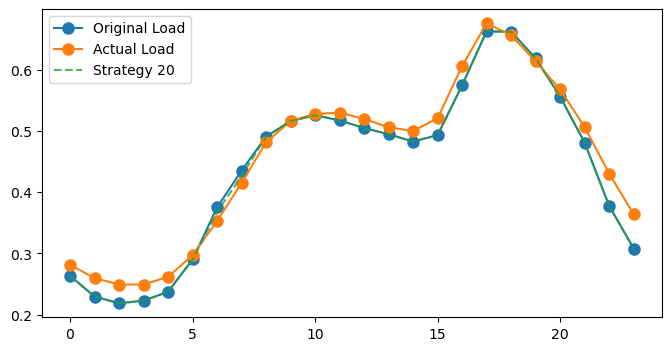

Found 0 relevant failed reflection cases for inquiry 0


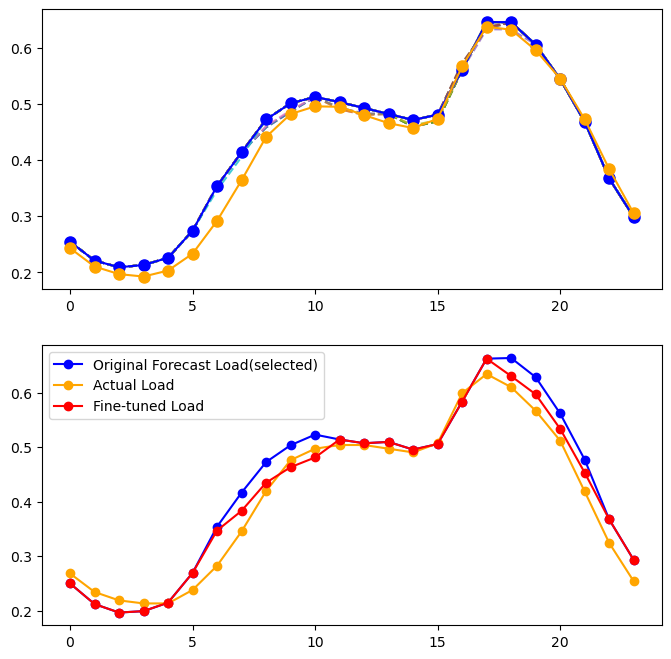

Original cost: 2544.6797387695315, Fine-tuned cost: 2499.5434118939343
以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 2/29
Found 3 similar days for inquiry 1
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_7，成本 2497.83, 原始成本 2500.05, (降低 2.23)
策略生成尝试 #2 (当前有效策略: 1/20)
发现有效策略 strategy_1，成本 2489.63, 原始成本 2500.05, (降低 10.43)
发现有效策略 strategy_7，成本 2497.83, 原始成本 2500.05, (降低 2.23)
发现有效策略 strategy_9，成本 2497.40, 原始成本 2500.05, (降低 2.66)
策略生成尝试 #3 (当前有效策略: 4/20)
give actual value
发现有效策略 strategy_1，成本 2489.63, 原始成本 2500.05, (降低 10.43)
发现有效策略 strategy_3，成本 2498.33, 原始成本 2500.05, (降低 1.73)
策略生成尝试 #4 (当前有效策略: 6/20)
give actual value
发现有效策略 strategy_1，成本 2489.63, 原始成本 2500.05, (降低 10.43)
发现有效策略 strategy_2，成本 2498.33, 原始成本 2500.05, (降低 1.73)
发现有效策略 strategy_3，成本 2497.83, 原始成本 2500.05, (降低 2.23)
发现有效策略 strategy_4，成本 2497.40, 原始成本 2500.05, (降低 2.66)
发现有效策略 strategy_9，成本 2496.96, 原始成本 2500.05, (降低 3.09)

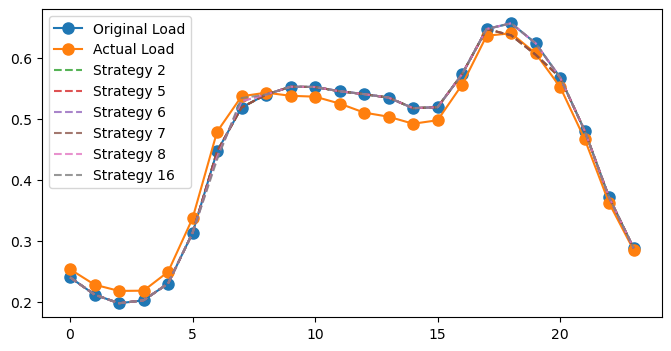

Found 0 relevant failed reflection cases for inquiry 1


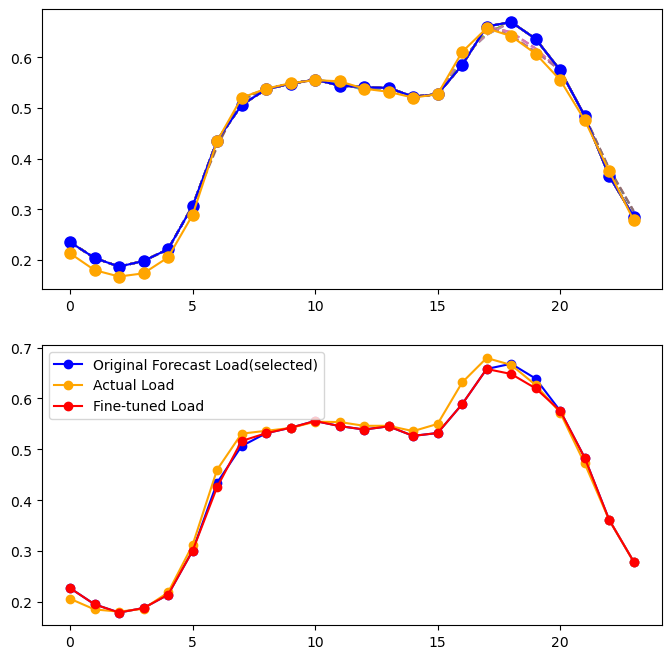

Original cost: 2565.0915869140626, Fine-tuned cost: 2577.367178311044
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_6，成本 2556.05, 原始成本 2565.09, (降低 9.04)
发现有效策略 strategy_9，成本 2563.03, 原始成本 2565.09, (降低 2.06)
策略生成尝试 #2 (当前有效策略: 2/5)
give actual value
发现有效策略 strategy_6，成本 2555.26, 原始成本 2565.09, (降低 9.84)
发现有效策略 strategy_9，成本 2563.06, 原始成本 2565.09, (降低 2.03)
策略生成尝试 #3 (当前有效策略: 4/5)
give actual value
发现有效策略 strategy_6，成本 2555.26, 原始成本 2565.09, (降低 9.84)
2554.885662841797
2538.455295102489


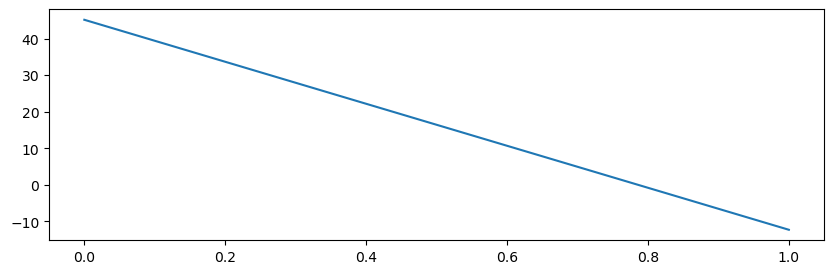

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 3/29
Found 3 similar days for inquiry 2
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_2，成本 2568.78, 原始成本 2571.27, (降低 2.49)
发现有效策略 strategy_3，成本 2563.97, 原始成本 2571.27, (降低 7.30)
发现有效策略 strategy_4，成本 2568.83, 原始成本 2571.27, (降低 2.44)
发现有效策略 strategy_7，成本 2567.58, 原始成本 2571.27, (降低 3.68)
发现有效策略 strategy_8，成本 2568.80, 原始成本 2571.27, (降低 2.47)
发现有效策略 strategy_10，成本 2565.37, 原始成本 2571.27, (降低 5.90)
策略生成尝试 #2 (当前有效策略: 6/20)
发现有效策略 strategy_1，成本 2568.24, 原始成本 2571.27, (降低 3.03)
发现有效策略 strategy_2，成本 2568.78, 原始成本 2571.27, (降低 2.49)
发现有效策略 strategy_3，成本 2563.97, 原始成本 2571.27, (降低 7.30)
发现有效策略 strategy_4，成本 2568.83, 原始成本 2571.27, (降低 2.44)
发现有效策略 strategy_7，成本 2567.58, 原始成本 2571.27, (降低 3.68)
发现有效策略 strategy_8，成本 2568.80, 原始成本 2571.27, (降低 2.47)
发现有效策略 strategy_10，成本 2565.37, 原始成本 2571.27, (降低 5.90)
策略生成尝试 #3 (当前有效策略: 13/20)
give actual value
发现有效策

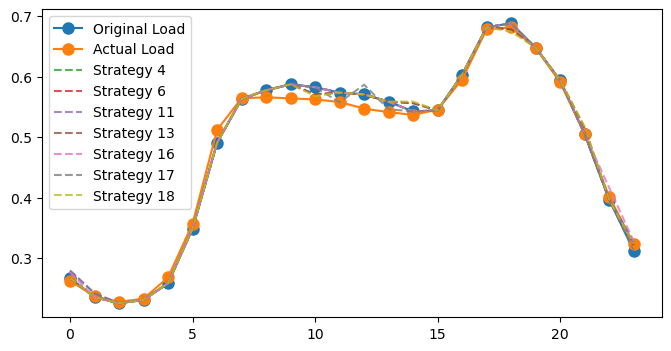

Found 1 relevant failed reflection cases for inquiry 2


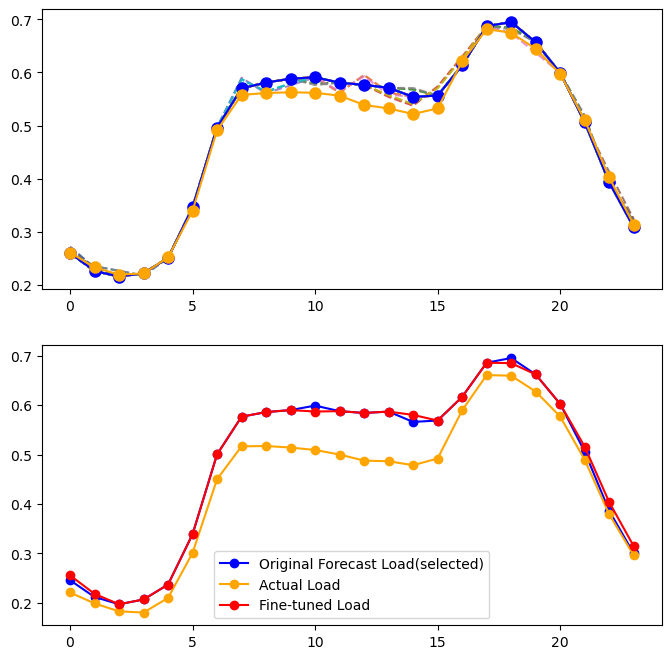

Original cost: 2672.1360458984377, Fine-tuned cost: 2685.1734864649657
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_1，成本 2653.97, 原始成本 2672.14, (降低 18.17)
发现有效策略 strategy_4，成本 2662.84, 原始成本 2672.14, (降低 9.29)
发现有效策略 strategy_8，成本 2669.89, 原始成本 2672.14, (降低 2.25)
发现有效策略 strategy_9，成本 2668.83, 原始成本 2672.14, (降低 3.31)
策略生成尝试 #2 (当前有效策略: 4/5)
give actual value
发现有效策略 strategy_1，成本 2650.92, 原始成本 2672.14, (降低 21.22)
2593.9691238606774
2587.361358889981


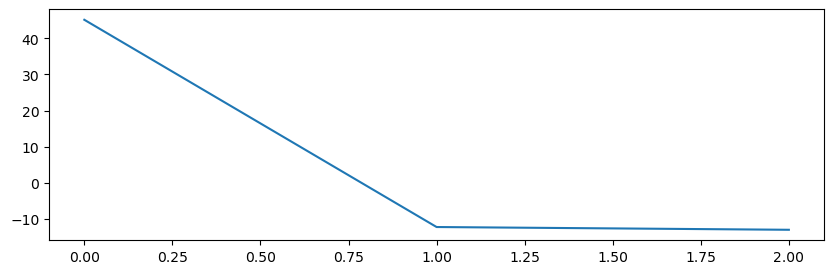

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 4/29
Found 3 similar days for inquiry 3
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_5，成本 2570.25, 原始成本 2574.45, (降低 4.20)
发现有效策略 strategy_8，成本 2568.18, 原始成本 2574.45, (降低 6.27)
策略生成尝试 #2 (当前有效策略: 2/20)
发现有效策略 strategy_6，成本 2571.79, 原始成本 2574.45, (降低 2.66)
发现有效策略 strategy_8，成本 2569.19, 原始成本 2574.45, (降低 5.25)
策略生成尝试 #3 (当前有效策略: 4/20)
give actual value
发现有效策略 strategy_8，成本 2569.19, 原始成本 2574.45, (降低 5.25)
发现有效策略 strategy_10，成本 2568.62, 原始成本 2574.45, (降低 5.82)
策略生成尝试 #4 (当前有效策略: 6/20)
give actual value
发现有效策略 strategy_6，成本 2571.22, 原始成本 2574.45, (降低 3.22)
发现有效策略 strategy_9，成本 2572.33, 原始成本 2574.45, (降低 2.12)
发现有效策略 strategy_10，成本 2566.80, 原始成本 2574.45, (降低 7.65)
策略生成尝试 #5 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_6，成本 2569.19, 原始成本 2574.45, (降低 5.25)
发现有效策略 strategy_9，成本 2571.22, 原始成本 2574.45, (降低 3.22)
策略生成尝试 #6 (当前有效策略: 11/20)
gi

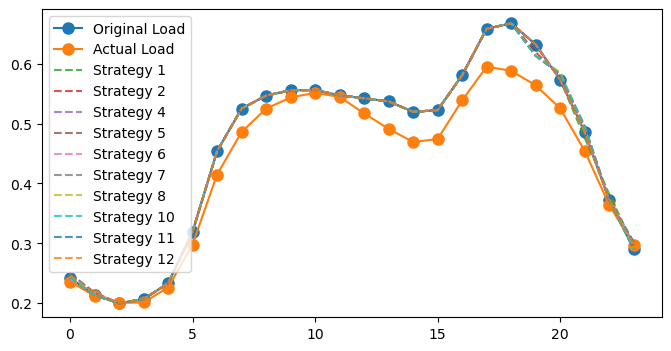

Found 1 relevant failed reflection cases for inquiry 3


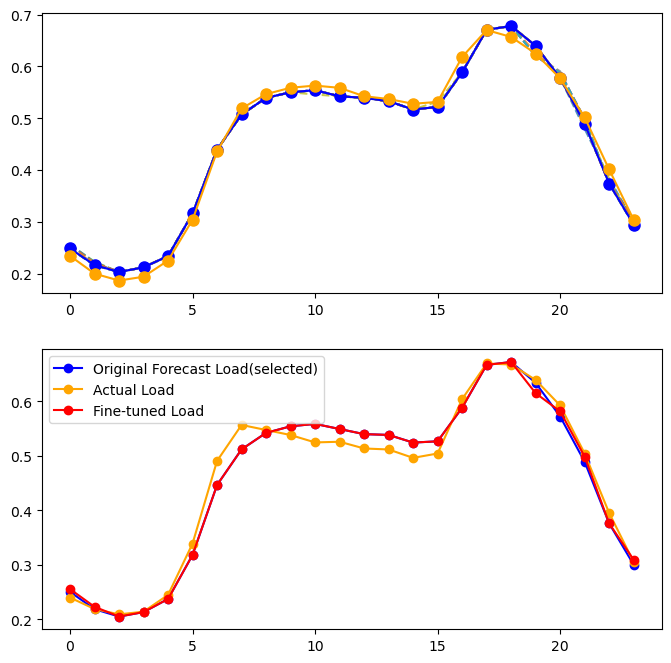

Original cost: 2630.5475029296877, Fine-tuned cost: 2630.102619643277
2603.11371862793
2598.0466740783054


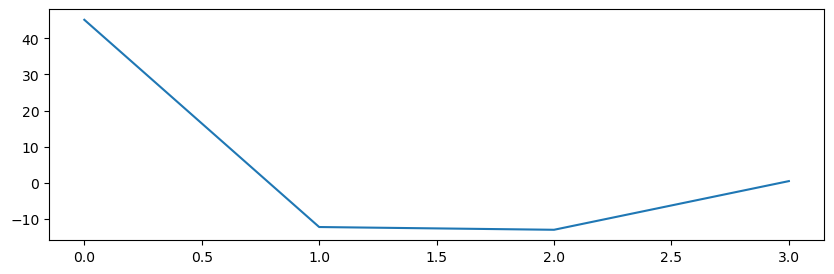

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 5/29
Found 3 similar days for inquiry 4
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_7，成本 2597.48, 原始成本 2601.59, (降低 4.11)
发现有效策略 strategy_9，成本 2593.15, 原始成本 2601.59, (降低 8.44)
策略生成尝试 #2 (当前有效策略: 2/20)
发现有效策略 strategy_3，成本 2599.64, 原始成本 2601.59, (降低 1.95)
发现有效策略 strategy_6，成本 2595.88, 原始成本 2601.59, (降低 5.70)
发现有效策略 strategy_7，成本 2597.48, 原始成本 2601.59, (降低 4.11)
策略生成尝试 #3 (当前有效策略: 5/20)
give actual value
发现有效策略 strategy_2，成本 2591.93, 原始成本 2601.59, (降低 9.66)
发现有效策略 strategy_6，成本 2593.23, 原始成本 2601.59, (降低 8.36)
发现有效策略 strategy_7，成本 2597.48, 原始成本 2601.59, (降低 4.11)
策略生成尝试 #4 (当前有效策略: 8/20)
give actual value
发现有效策略 strategy_2，成本 2591.93, 原始成本 2601.59, (降低 9.66)
发现有效策略 strategy_6，成本 2593.23, 原始成本 2601.59, (降低 8.36)
发现有效策略 strategy_7，成本 2597.48, 原始成本 2601.59, (降低 4.11)
发现有效策略 strategy_10，成本 2600.54, 原始成本 2601.59, (降低 1.05)
策略生成尝试 #5 (当前有效策略:

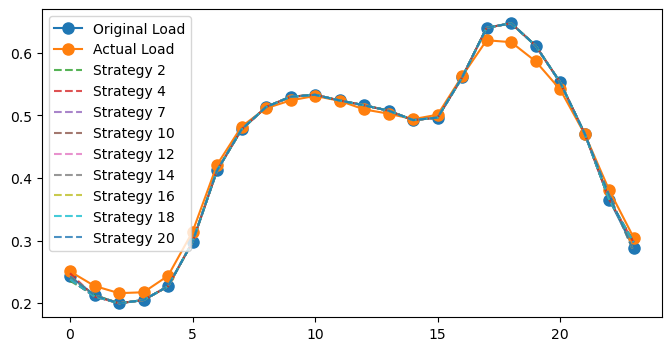

Found 1 relevant failed reflection cases for inquiry 4


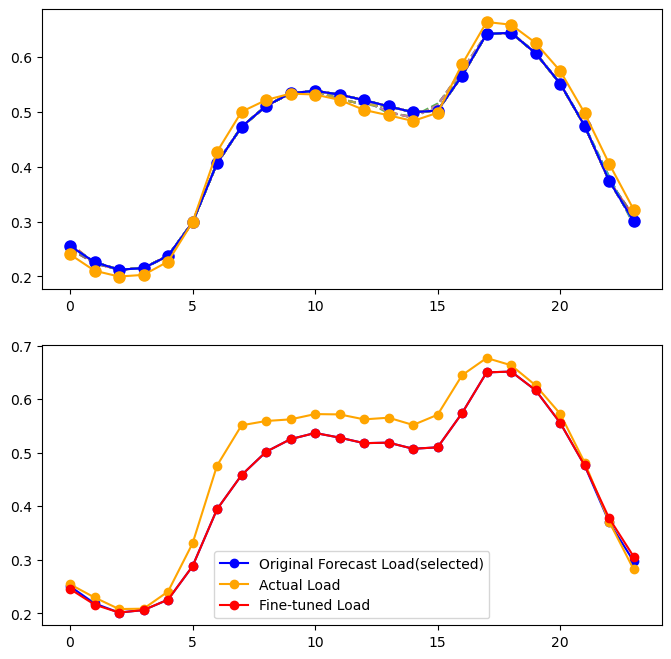

Original cost: 3008.7997490234375, Fine-tuned cost: 3017.0652936165625
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_2，成本 2998.40, 原始成本 3008.80, (降低 10.40)
发现有效策略 strategy_3，成本 2999.75, 原始成本 3008.80, (降低 9.05)
发现有效策略 strategy_5，成本 2996.67, 原始成本 3008.80, (降低 12.13)
发现有效策略 strategy_7，成本 3006.55, 原始成本 3008.80, (降低 2.25)
策略生成尝试 #2 (当前有效策略: 4/5)
give actual value
发现有效策略 strategy_2，成本 2998.40, 原始成本 3008.80, (降低 10.40)
2684.2509247070316
2681.850397985957


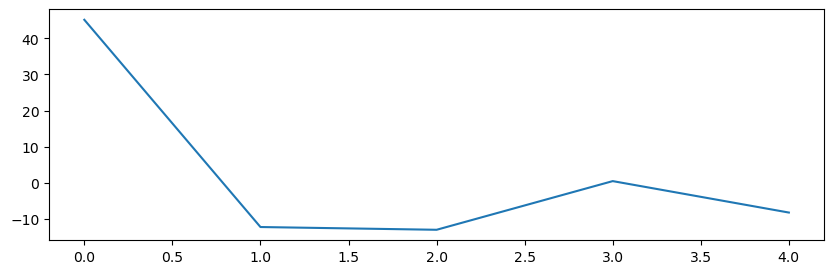

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 6/29
Found 3 similar days for inquiry 5
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2377.68, 原始成本 2390.97, (降低 13.30)
发现有效策略 strategy_3，成本 2389.20, 原始成本 2390.97, (降低 1.77)
发现有效策略 strategy_4，成本 2388.71, 原始成本 2390.97, (降低 2.27)
发现有效策略 strategy_5，成本 2388.01, 原始成本 2390.97, (降低 2.96)
发现有效策略 strategy_8，成本 2385.06, 原始成本 2390.97, (降低 5.92)
发现有效策略 strategy_10，成本 2385.39, 原始成本 2390.97, (降低 5.59)
策略生成尝试 #2 (当前有效策略: 6/20)
发现有效策略 strategy_1，成本 2377.74, 原始成本 2390.97, (降低 13.24)
发现有效策略 strategy_2，成本 2389.07, 原始成本 2390.97, (降低 1.91)
发现有效策略 strategy_3，成本 2388.85, 原始成本 2390.97, (降低 2.12)
发现有效策略 strategy_4，成本 2388.03, 原始成本 2390.97, (降低 2.94)
发现有效策略 strategy_5，成本 2385.23, 原始成本 2390.97, (降低 5.74)
发现有效策略 strategy_9，成本 2389.63, 原始成本 2390.97, (降低 1.34)
策略生成尝试 #3 (当前有效策略: 12/20)
give actual value
发现有效策略 strategy_1，成本 2378.51, 原始成本 2390.97, (降低 12.46)
发现有

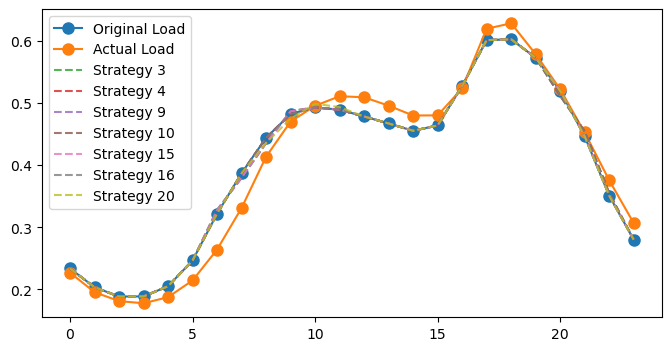

Found 1 relevant failed reflection cases for inquiry 5


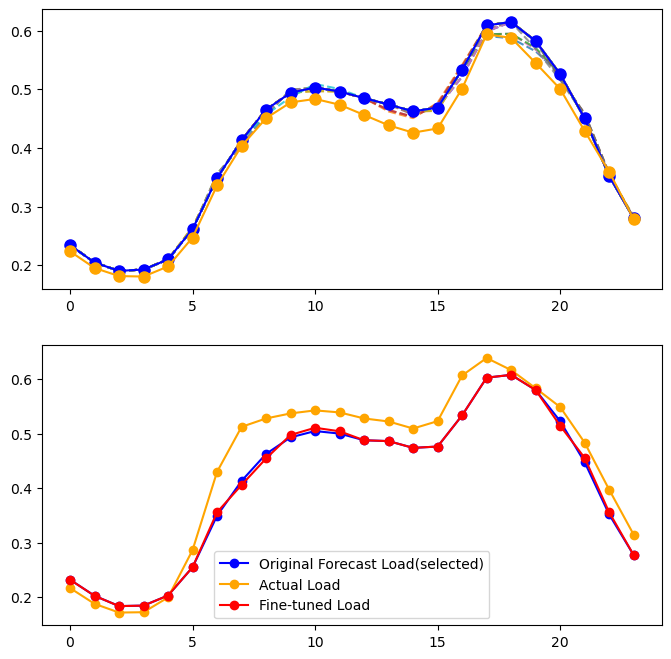

Original cost: 2984.539114257812, Fine-tuned cost: 2977.550252272832
2734.298956298828
2731.133707033769


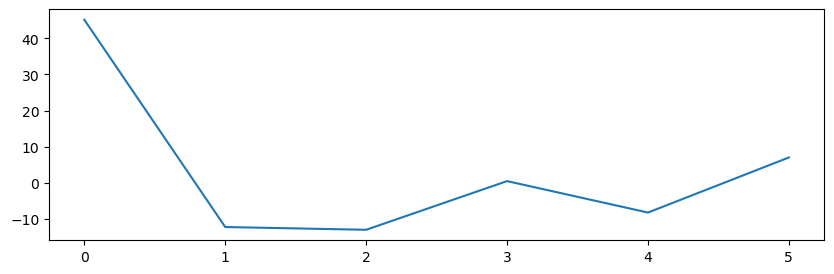

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 7/29
Found 3 similar days for inquiry 6
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_2，成本 2399.63, 原始成本 2413.62, (降低 13.99)
发现有效策略 strategy_7，成本 2411.69, 原始成本 2413.62, (降低 1.93)
策略生成尝试 #2 (当前有效策略: 2/20)
发现有效策略 strategy_2，成本 2399.63, 原始成本 2413.62, (降低 13.99)
发现有效策略 strategy_3，成本 2410.43, 原始成本 2413.62, (降低 3.19)
发现有效策略 strategy_7，成本 2411.69, 原始成本 2413.62, (降低 1.93)
发现有效策略 strategy_10，成本 2407.06, 原始成本 2413.62, (降低 6.56)
策略生成尝试 #3 (当前有效策略: 6/20)
give actual value
发现有效策略 strategy_2，成本 2399.63, 原始成本 2413.62, (降低 13.99)
发现有效策略 strategy_3，成本 2410.43, 原始成本 2413.62, (降低 3.19)
发现有效策略 strategy_4，成本 2411.69, 原始成本 2413.62, (降低 1.93)
发现有效策略 strategy_9，成本 2407.06, 原始成本 2413.62, (降低 6.56)
发现有效策略 strategy_10，成本 2406.28, 原始成本 2413.62, (降低 7.34)
策略生成尝试 #4 (当前有效策略: 11/20)
give actual value
发现有效策略 strategy_2，成本 2399.63, 原始成本 2413.62, (降低 13.99)
发现有效策略 strat

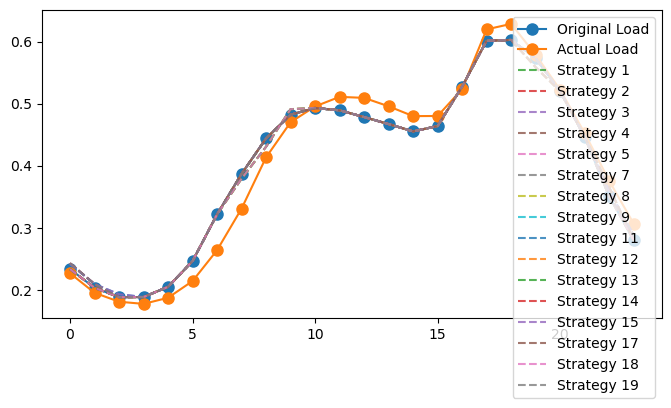

Found 1 relevant failed reflection cases for inquiry 6


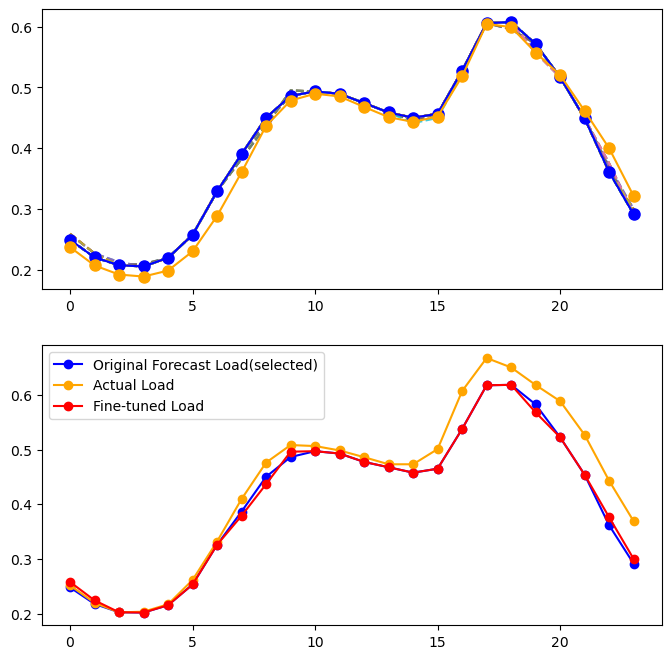

Original cost: 2842.0847583007812, Fine-tuned cost: 2842.877226715058
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_6，成本 2834.21, 原始成本 2842.08, (降低 7.87)
策略生成尝试 #2 (当前有效策略: 1/5)
give actual value
发现有效策略 strategy_4，成本 2835.18, 原始成本 2842.08, (降低 6.90)
发现有效策略 strategy_5，成本 2832.37, 原始成本 2842.08, (降低 9.72)
发现有效策略 strategy_9，成本 2840.43, 原始成本 2842.08, (降低 1.66)
策略生成尝试 #3 (当前有效策略: 4/5)
give actual value
发现有效策略 strategy_4，成本 2836.27, 原始成本 2842.08, (降低 5.82)
2749.696928013393
2747.0970669882395


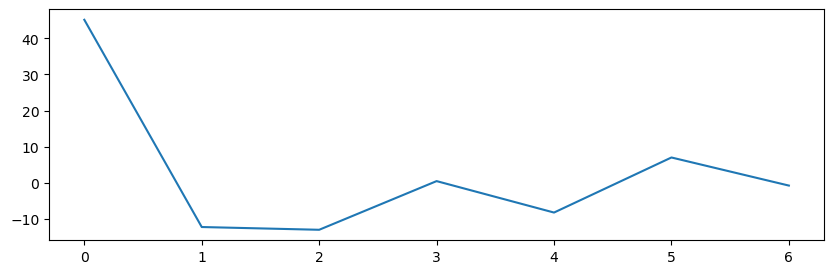

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 8/29
Found 3 similar days for inquiry 7
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_2，成本 2577.42, 原始成本 2581.15, (降低 3.73)
发现有效策略 strategy_8，成本 2571.91, 原始成本 2581.15, (降低 9.24)
策略生成尝试 #2 (当前有效策略: 2/20)
发现有效策略 strategy_2，成本 2577.42, 原始成本 2581.15, (降低 3.73)
发现有效策略 strategy_3，成本 2571.91, 原始成本 2581.15, (降低 9.24)
发现有效策略 strategy_10，成本 2574.68, 原始成本 2581.15, (降低 6.47)
策略生成尝试 #3 (当前有效策略: 5/20)
give actual value
发现有效策略 strategy_2，成本 2577.42, 原始成本 2581.15, (降低 3.73)
发现有效策略 strategy_3，成本 2571.91, 原始成本 2581.15, (降低 9.24)
发现有效策略 strategy_6，成本 2579.74, 原始成本 2581.15, (降低 1.41)
发现有效策略 strategy_10，成本 2574.68, 原始成本 2581.15, (降低 6.47)
策略生成尝试 #4 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_4，成本 2563.12, 原始成本 2581.15, (降低 18.03)
发现有效策略 strategy_5，成本 2577.84, 原始成本 2581.15, (降低 3.31)
发现有效策略 strategy_7，成本 2575.83, 原始成本 2581.15, (降低 5.32)
发现有效策略 strategy_

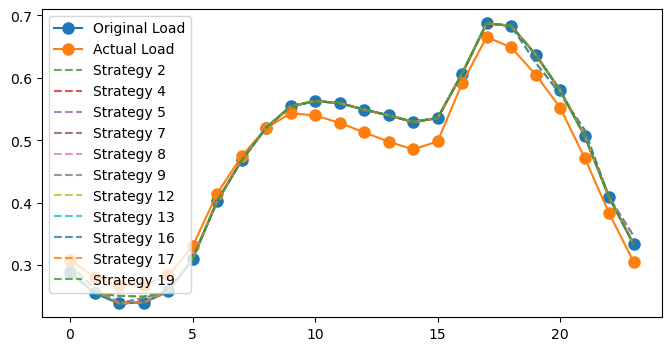

Found 1 relevant failed reflection cases for inquiry 7


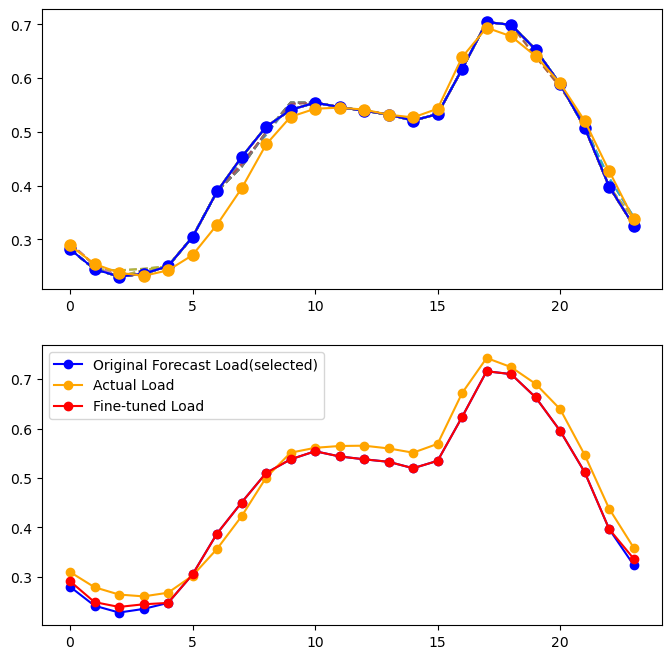

Original cost: 2929.290492675781, Fine-tuned cost: 2892.039974295318
2772.1461235961915
2765.214930401624


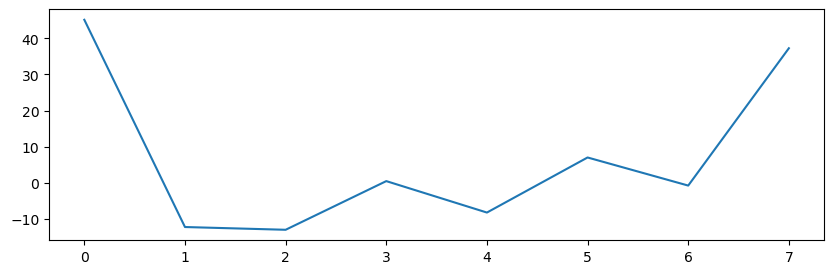

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: []
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 9/29
Found 3 similar days for inquiry 8
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2703.51, 原始成本 2721.18, (降低 17.67)
发现有效策略 strategy_4，成本 2706.03, 原始成本 2721.18, (降低 15.15)
发现有效策略 strategy_6，成本 2717.05, 原始成本 2721.18, (降低 4.13)
发现有效策略 strategy_7，成本 2712.92, 原始成本 2721.18, (降低 8.26)
发现有效策略 strategy_10，成本 2714.35, 原始成本 2721.18, (降低 6.83)
策略生成尝试 #2 (当前有效策略: 5/20)
发现有效策略 strategy_1，成本 2703.51, 原始成本 2721.18, (降低 17.67)
发现有效策略 strategy_3，成本 2717.63, 原始成本 2721.18, (降低 3.55)
发现有效策略 strategy_4，成本 2706.03, 原始成本 2721.18, (降低 15.15)
发现有效策略 strategy_5，成本 2711.48, 原始成本 2721.18, (降低 9.70)
发现有效策略 strategy_6，成本 2717.05, 原始成本 2721.18, (降低 4.13)
发现有效策略 strategy_7，成本 2708.93, 原始成本 2721.18, (降低 12.25)
发现有效策略 strategy_8，成本 2718.11, 原始成本 2721.18, (降低 3.07)
发现有效策略 strategy_10，成本 2714.35, 原始成本 2721.18, (降低 6.83)
策略生成尝试 #3 (当前有效策略: 13/20)
give actual value


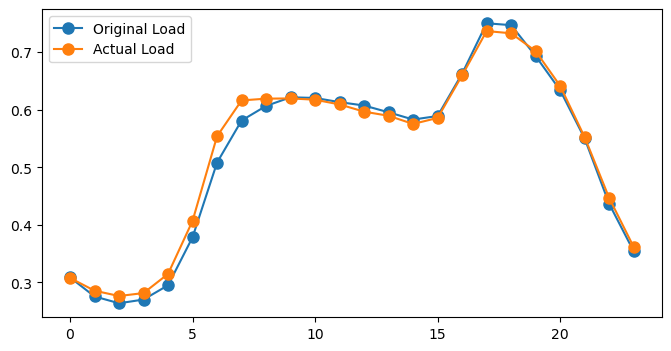

Inquiry 8: No valid strategy found, using original curve as fine-tuned result.
2807.9041499565974
2801.743089339204


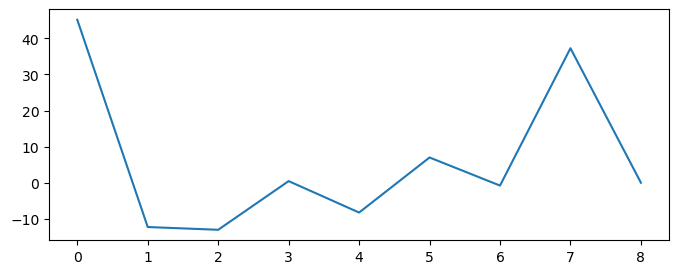

Processing inquiry 10/29
Found 3 similar days for inquiry 9
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2732.27, 原始成本 2751.02, (降低 18.75)
发现有效策略 strategy_9，成本 2746.18, 原始成本 2751.02, (降低 4.84)
发现有效策略 strategy_10，成本 2749.77, 原始成本 2751.02, (降低 1.25)
策略生成尝试 #2 (当前有效策略: 3/20)
发现有效策略 strategy_1，成本 2732.27, 原始成本 2751.02, (降低 18.75)
发现有效策略 strategy_2，成本 2747.89, 原始成本 2751.02, (降低 3.13)
发现有效策略 strategy_4，成本 2744.78, 原始成本 2751.02, (降低 6.24)
发现有效策略 strategy_5，成本 2746.73, 原始成本 2751.02, (降低 4.29)
发现有效策略 strategy_7，成本 2747.81, 原始成本 2751.02, (降低 3.21)
发现有效策略 strategy_9，成本 2749.64, 原始成本 2751.02, (降低 1.38)
发现有效策略 strategy_10，成本 2747.42, 原始成本 2751.02, (降低 3.60)
策略生成尝试 #3 (当前有效策略: 10/20)
give actual value
发现有效策略 strategy_1，成本 2728.46, 原始成本 2751.02, (降低 22.56)
发现有效策略 strategy_2，成本 2746.36, 原始成本 2751.02, (降低 4.66)
发现有效策略 strategy_4，成本 2744.78, 原始成本 2751.02, (降低 6.24)
发现有效策略 strategy_5，成本 2746.73, 原始成本 2751.02, (降低 4.29)
发现有效策略 strategy_6，成本 2747.81, 原始

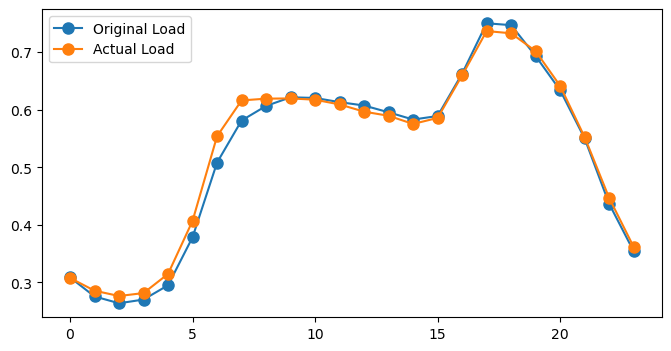

Inquiry 9: No valid strategy found, using original curve as fine-tuned result.
2822.313160058594
2816.76820550294


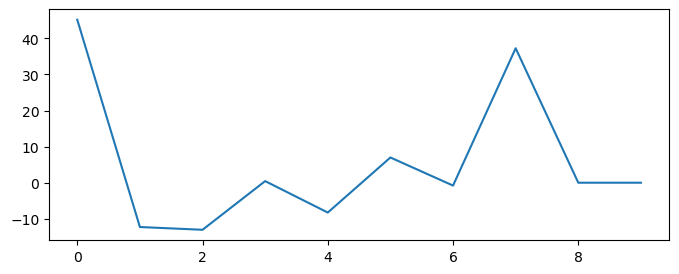

Processing inquiry 11/29
Found 3 similar days for inquiry 10
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2709.13, 原始成本 2721.18, (降低 12.05)
发现有效策略 strategy_4，成本 2712.16, 原始成本 2721.18, (降低 9.03)
发现有效策略 strategy_7，成本 2710.42, 原始成本 2721.18, (降低 10.76)
策略生成尝试 #2 (当前有效策略: 3/20)
发现有效策略 strategy_1，成本 2707.78, 原始成本 2721.18, (降低 13.40)
发现有效策略 strategy_2，成本 2712.42, 原始成本 2721.18, (降低 8.76)
发现有效策略 strategy_3，成本 2716.10, 原始成本 2721.18, (降低 5.08)
发现有效策略 strategy_4，成本 2709.13, 原始成本 2721.18, (降低 12.05)
发现有效策略 strategy_5，成本 2712.16, 原始成本 2721.18, (降低 9.03)
发现有效策略 strategy_6，成本 2712.22, 原始成本 2721.18, (降低 8.96)
发现有效策略 strategy_7，成本 2710.42, 原始成本 2721.18, (降低 10.76)
发现有效策略 strategy_8，成本 2713.12, 原始成本 2721.18, (降低 8.06)
发现有效策略 strategy_9，成本 2707.62, 原始成本 2721.18, (降低 13.56)
发现有效策略 strategy_10，成本 2714.29, 原始成本 2721.18, (降低 6.89)
策略生成尝试 #3 (当前有效策略: 13/20)
give actual value
发现有效策略 strategy_1，成本 2705.11, 原始成本 2721.18, (降低 16.07)
发现有效策略 strategy_2，成本 2713.85

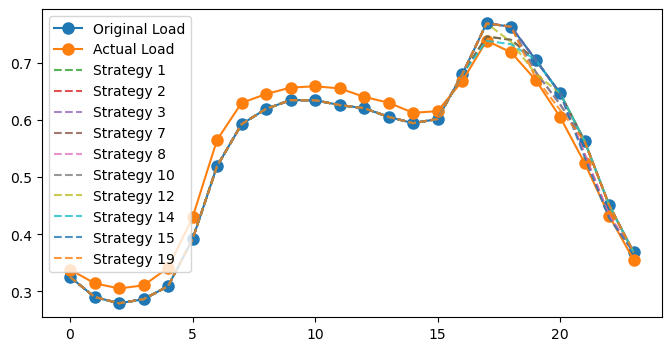

Found 1 relevant failed reflection cases for inquiry 10


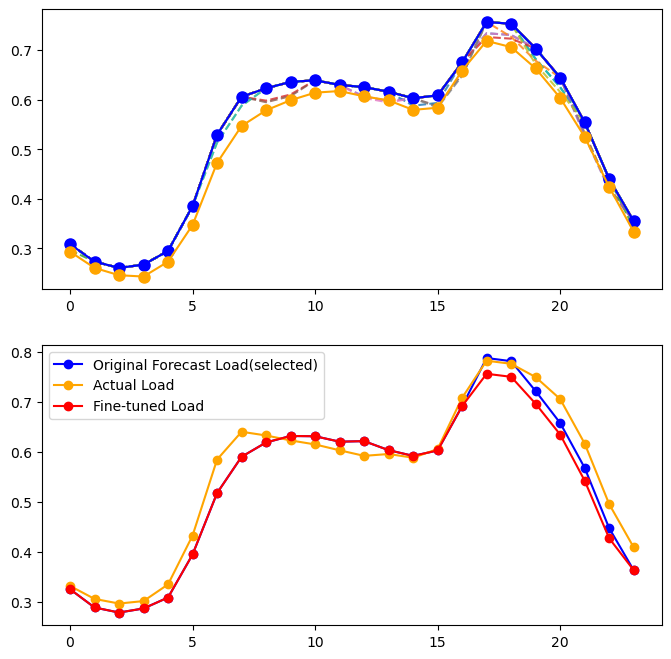

Original cost: 3034.003692382812, Fine-tuned cost: 3134.6436936541522
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_2，成本 3031.94, 原始成本 3034.00, (降低 2.07)
发现有效策略 strategy_3，成本 3015.45, 原始成本 3034.00, (降低 18.56)
发现有效策略 strategy_6，成本 3019.11, 原始成本 3034.00, (降低 14.90)
发现有效策略 strategy_10，成本 3028.90, 原始成本 3034.00, (降低 5.10)
策略生成尝试 #2 (当前有效策略: 4/5)
give actual value
发现有效策略 strategy_2，成本 3031.94, 原始成本 3034.00, (降低 2.07)
2841.55775390625
2845.66597715305


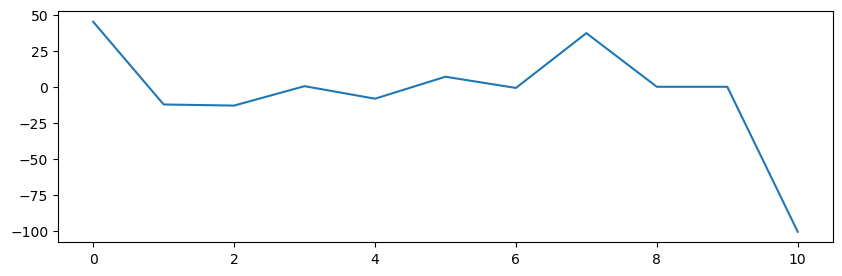

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 12/29
Found 3 similar days for inquiry 11
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2804.37, 原始成本 2816.96, (降低 12.59)
发现有效策略 strategy_3，成本 2802.62, 原始成本 2816.96, (降低 14.33)
发现有效策略 strategy_5，成本 2808.63, 原始成本 2816.96, (降低 8.32)
发现有效策略 strategy_7，成本 2811.70, 原始成本 2816.96, (降低 5.26)
策略生成尝试 #2 (当前有效策略: 4/20)
发现有效策略 strategy_1，成本 2802.89, 原始成本 2816.96, (降低 14.06)
发现有效策略 strategy_2，成本 2802.51, 原始成本 2816.96, (降低 14.44)
发现有效策略 strategy_3，成本 2808.63, 原始成本 2816.96, (降低 8.32)
发现有效策略 strategy_4，成本 2811.70, 原始成本 2816.96, (降低 5.26)
发现有效策略 strategy_5，成本 2810.23, 原始成本 2816.96, (降低 6.72)
发现有效策略 strategy_7，成本 2805.94, 原始成本 2816.96, (降低 11.01)
发现有效策略 strategy_8，成本 2813.19, 原始成本 2816.96, (降低 3.77)
策略生成尝试 #3 (当前有效策略: 11/20)
give actual value
发现有效策略 strategy_1，成本 2798.91, 原始成本 2816.96, (降低 18.05)
发现有效策略 strategy_2，成本 2800.58, 原始成本 2816.96, (降低 1

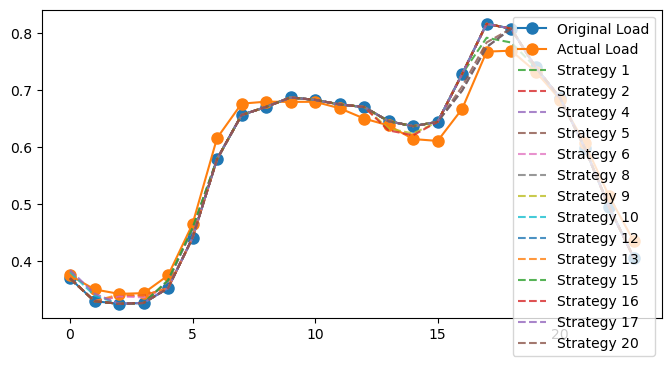

Found 1 relevant failed reflection cases for inquiry 11


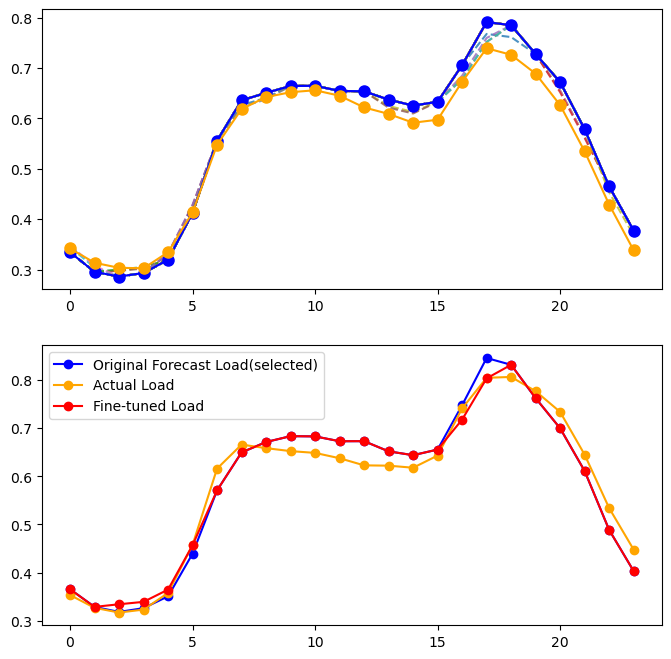

Original cost: 3002.473008789062, Fine-tuned cost: 2998.784376485753
2854.967358479818
2858.425843764109


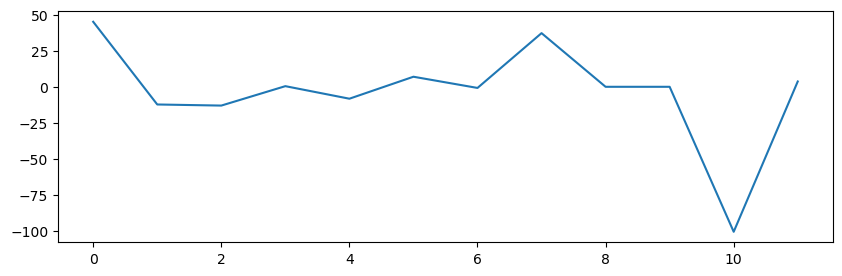

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 13/29
Found 3 similar days for inquiry 12
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2809.62, 原始成本 2816.96, (降低 7.34)
发现有效策略 strategy_3，成本 2794.50, 原始成本 2816.96, (降低 22.45)
发现有效策略 strategy_5，成本 2812.26, 原始成本 2816.96, (降低 4.69)
发现有效策略 strategy_7，成本 2802.32, 原始成本 2816.96, (降低 14.63)
发现有效策略 strategy_8，成本 2813.49, 原始成本 2816.96, (降低 3.47)
发现有效策略 strategy_10，成本 2815.66, 原始成本 2816.96, (降低 1.30)
策略生成尝试 #2 (当前有效策略: 6/20)
发现有效策略 strategy_1，成本 2802.70, 原始成本 2816.96, (降低 14.26)
发现有效策略 strategy_2，成本 2795.67, 原始成本 2816.96, (降低 21.28)
发现有效策略 strategy_4，成本 2808.13, 原始成本 2816.96, (降低 8.83)
发现有效策略 strategy_6，成本 2804.81, 原始成本 2816.96, (降低 12.14)
发现有效策略 strategy_9，成本 2815.04, 原始成本 2816.96, (降低 1.92)
发现有效策略 strategy_10，成本 2806.22, 原始成本 2816.96, (降低 10.74)
策略生成尝试 #3 (当前有效策略: 12/20)
give actual value
发现有效策略 strategy_1，成本 2799.66, 原始成本 2816.96, (降低

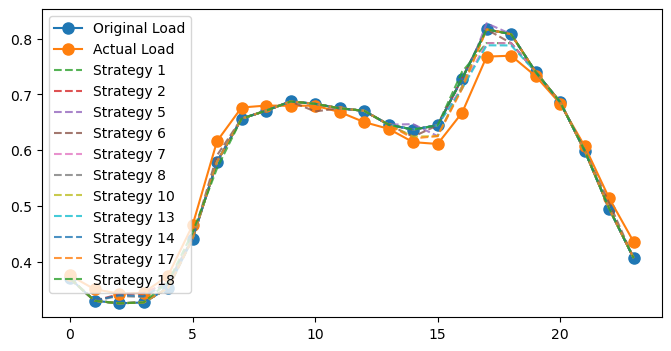

Found 1 relevant failed reflection cases for inquiry 12


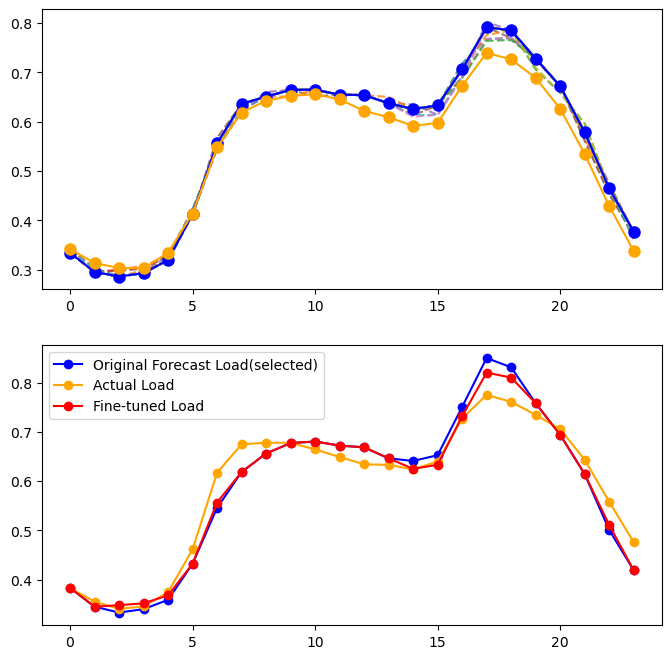

Original cost: 3093.523514160156, Fine-tuned cost: 3045.0606492294637
2873.31783199369
2872.7823672614436


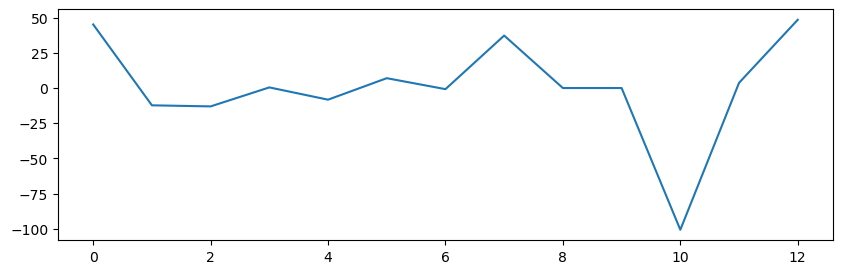

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 14/29
Found 3 similar days for inquiry 13
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2734.46, 原始成本 2746.98, (降低 12.52)
发现有效策略 strategy_3，成本 2737.08, 原始成本 2746.98, (降低 9.90)
发现有效策略 strategy_6，成本 2738.59, 原始成本 2746.98, (降低 8.39)
发现有效策略 strategy_7，成本 2736.92, 原始成本 2746.98, (降低 10.06)
发现有效策略 strategy_9，成本 2743.11, 原始成本 2746.98, (降低 3.87)
策略生成尝试 #2 (当前有效策略: 5/20)
发现有效策略 strategy_1，成本 2734.46, 原始成本 2746.98, (降低 12.52)
发现有效策略 strategy_3，成本 2737.08, 原始成本 2746.98, (降低 9.90)
发现有效策略 strategy_6，成本 2738.59, 原始成本 2746.98, (降低 8.39)
发现有效策略 strategy_7，成本 2736.92, 原始成本 2746.98, (降低 10.06)
发现有效策略 strategy_9，成本 2743.11, 原始成本 2746.98, (降低 3.87)
策略生成尝试 #3 (当前有效策略: 10/20)
give actual value
发现有效策略 strategy_1，成本 2734.46, 原始成本 2746.98, (降低 12.52)
发现有效策略 strategy_2，成本 2737.08, 原始成本 2746.98, (降低 9.90)
发现有效策略 strategy_3，成本 2738.59, 原始成本 2746.98, (降低 8.

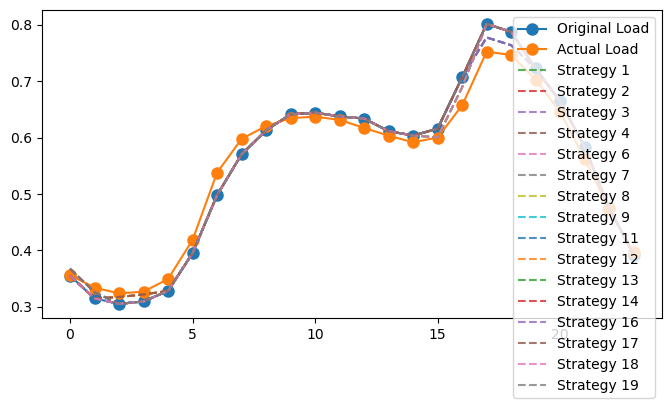

Found 1 relevant failed reflection cases for inquiry 13


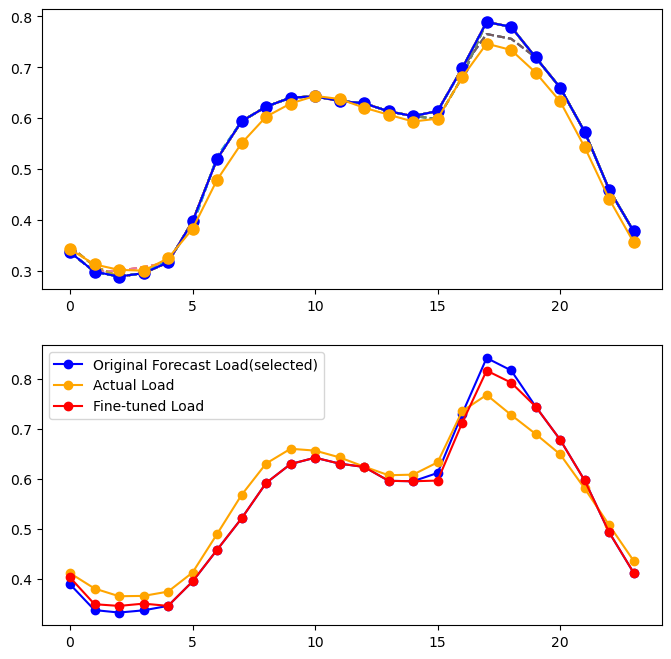

Original cost: 3062.3299511718747, Fine-tuned cost: 3035.6086149324506
2886.818697649275
2884.412813523658


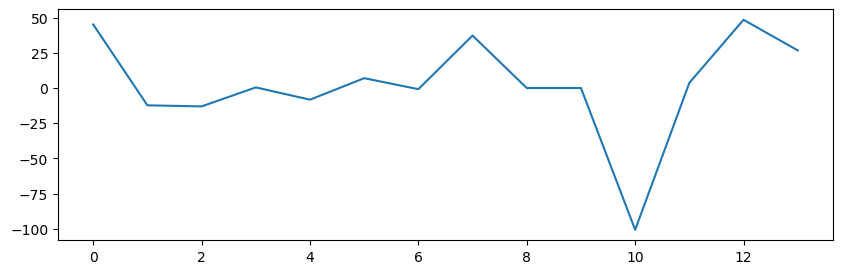

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 15/29
Found 3 similar days for inquiry 14
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2682.17, 原始成本 2699.94, (降低 17.77)
发现有效策略 strategy_4，成本 2692.13, 原始成本 2699.94, (降低 7.82)
发现有效策略 strategy_5，成本 2691.11, 原始成本 2699.94, (降低 8.83)
发现有效策略 strategy_9，成本 2696.35, 原始成本 2699.94, (降低 3.60)
发现有效策略 strategy_10，成本 2697.45, 原始成本 2699.94, (降低 2.49)
策略生成尝试 #2 (当前有效策略: 5/20)
发现有效策略 strategy_1，成本 2680.32, 原始成本 2699.94, (降低 19.62)
发现有效策略 strategy_3，成本 2697.80, 原始成本 2699.94, (降低 2.14)
发现有效策略 strategy_4，成本 2695.54, 原始成本 2699.94, (降低 4.40)
发现有效策略 strategy_5，成本 2683.10, 原始成本 2699.94, (降低 16.84)
发现有效策略 strategy_6，成本 2697.52, 原始成本 2699.94, (降低 2.42)
发现有效策略 strategy_9，成本 2695.85, 原始成本 2699.94, (降低 4.09)
策略生成尝试 #3 (当前有效策略: 11/20)
give actual value
发现有效策略 strategy_1，成本 2680.32, 原始成本 2699.94, (降低 19.62)
发现有效策略 strategy_2，成本 2697.80, 原始成本 2699.94, (降低 2.

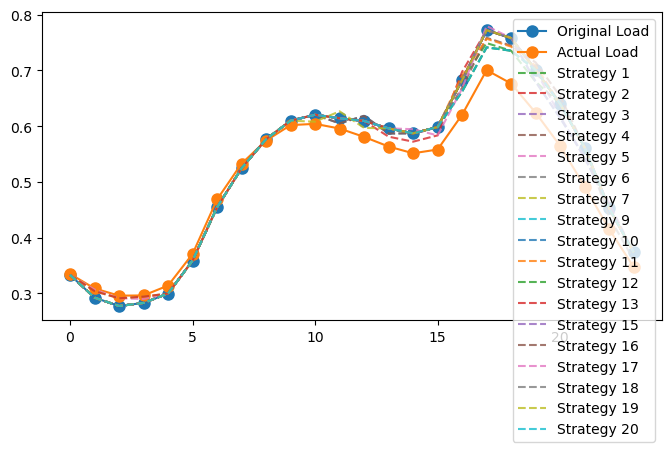

Found 1 relevant failed reflection cases for inquiry 14


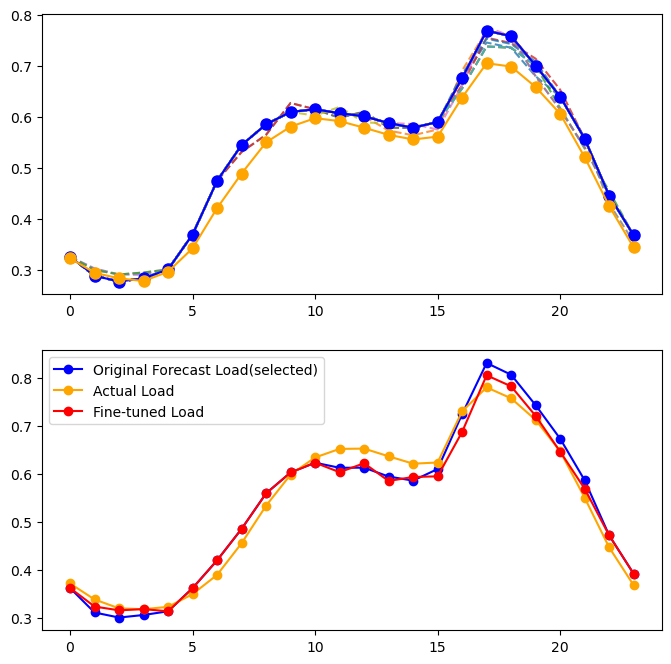

Original cost: 2887.7637436523437, Fine-tuned cost: 2867.3232435822392
2886.881700716146
2883.2735088608965


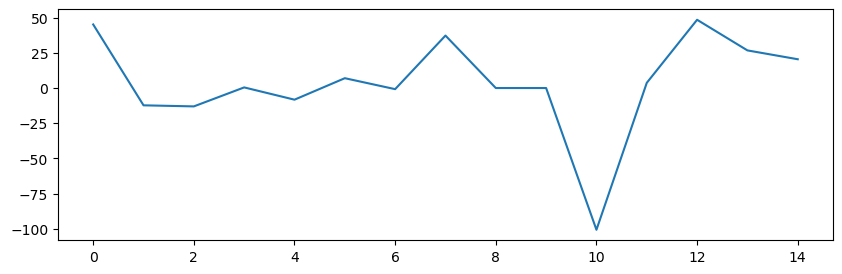

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 16/29
Found 3 similar days for inquiry 15
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2804.37, 原始成本 2816.96, (降低 12.59)
发现有效策略 strategy_3，成本 2801.34, 原始成本 2816.96, (降低 15.61)
发现有效策略 strategy_5，成本 2805.31, 原始成本 2816.96, (降低 11.65)
发现有效策略 strategy_7，成本 2811.09, 原始成本 2816.96, (降低 5.86)
策略生成尝试 #2 (当前有效策略: 4/20)
发现有效策略 strategy_1，成本 2799.66, 原始成本 2816.96, (降低 17.29)
发现有效策略 strategy_2，成本 2792.15, 原始成本 2816.96, (降低 24.81)
发现有效策略 strategy_3，成本 2804.56, 原始成本 2816.96, (降低 12.40)
发现有效策略 strategy_4，成本 2815.67, 原始成本 2816.96, (降低 1.29)
发现有效策略 strategy_5，成本 2805.18, 原始成本 2816.96, (降低 11.77)
发现有效策略 strategy_8，成本 2810.73, 原始成本 2816.96, (降低 6.23)
发现有效策略 strategy_9，成本 2804.56, 原始成本 2816.96, (降低 12.39)
发现有效策略 strategy_10，成本 2813.32, 原始成本 2816.96, (降低 3.63)
策略生成尝试 #3 (当前有效策略: 12/20)
give actual value
发现有效策略 strategy_1，成本 2802.26, 原始成本 2816.96, (降

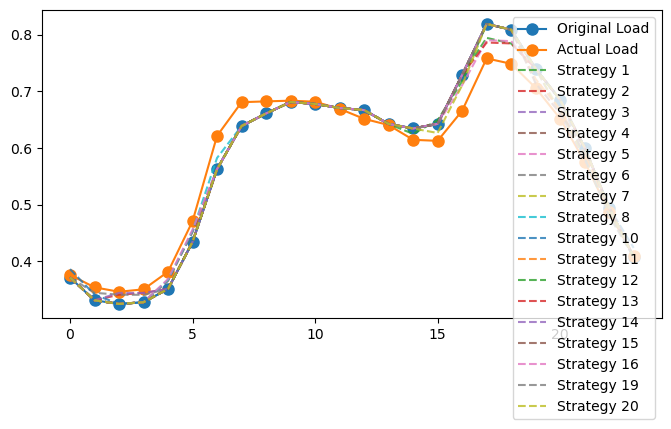

Found 1 relevant failed reflection cases for inquiry 15


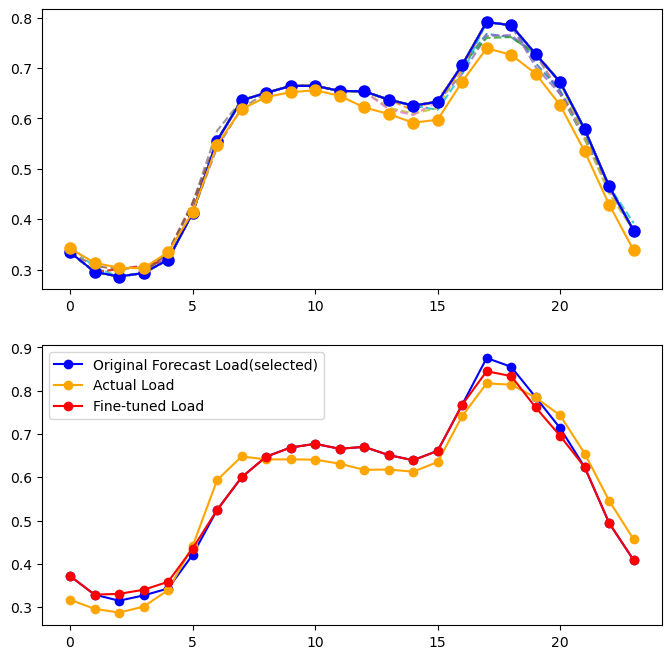

Original cost: 3061.2154790039062, Fine-tuned cost: 3077.058391430586
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_1，成本 3047.40, 原始成本 3061.22, (降低 13.81)
发现有效策略 strategy_7，成本 3051.78, 原始成本 3061.22, (降低 9.43)
发现有效策略 strategy_10，成本 3054.82, 原始成本 3061.22, (降低 6.39)
策略生成尝试 #2 (当前有效策略: 3/5)
give actual value
发现有效策略 strategy_1，成本 3042.80, 原始成本 3061.22, (降低 18.42)
策略生成尝试 #3 (当前有效策略: 4/5)
give actual value
发现有效策略 strategy_1，成本 3042.80, 原始成本 3061.22, (降低 18.42)
2897.777561859131
2895.3850640215023


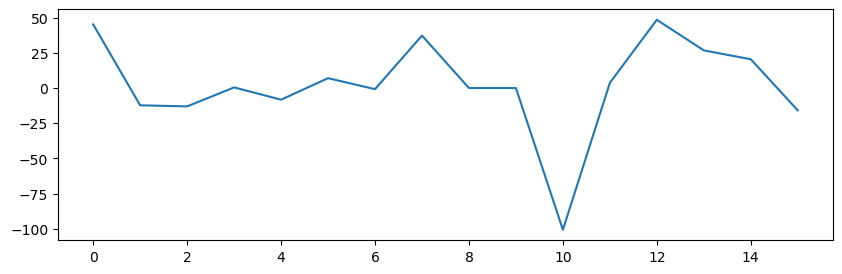

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 17/29
Found 3 similar days for inquiry 16
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2912.95, 原始成本 2925.52, (降低 12.57)
发现有效策略 strategy_3，成本 2914.79, 原始成本 2925.52, (降低 10.73)
发现有效策略 strategy_4，成本 2920.98, 原始成本 2925.52, (降低 4.54)
发现有效策略 strategy_5，成本 2922.32, 原始成本 2925.52, (降低 3.20)
发现有效策略 strategy_6，成本 2919.85, 原始成本 2925.52, (降低 5.67)
发现有效策略 strategy_7，成本 2921.43, 原始成本 2925.52, (降低 4.09)
策略生成尝试 #2 (当前有效策略: 6/20)
发现有效策略 strategy_1，成本 2912.95, 原始成本 2925.52, (降低 12.57)
发现有效策略 strategy_2，成本 2914.79, 原始成本 2925.52, (降低 10.73)
发现有效策略 strategy_3，成本 2920.98, 原始成本 2925.52, (降低 4.54)
发现有效策略 strategy_4，成本 2922.32, 原始成本 2925.52, (降低 3.20)
发现有效策略 strategy_5，成本 2919.85, 原始成本 2925.52, (降低 5.67)
发现有效策略 strategy_6，成本 2921.43, 原始成本 2925.52, (降低 4.09)
发现有效策略 strategy_7，成本 2914.41, 原始成本 2925.52, (降低 11.11)
策略生成尝试 #3 (当前有效策略: 13/20)
give actual va

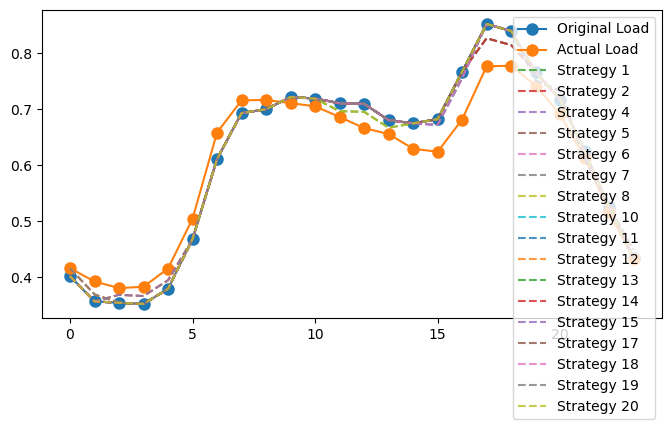

Found 1 relevant failed reflection cases for inquiry 16


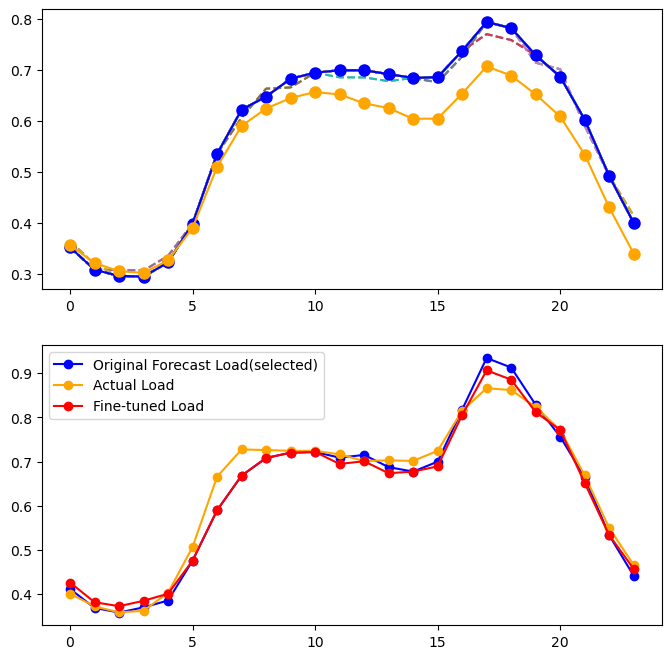

Original cost: 3159.699133300782, Fine-tuned cost: 3169.6870728322983
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_1，成本 3144.95, 原始成本 3159.70, (降低 14.75)
发现有效策略 strategy_9，成本 3149.30, 原始成本 3159.70, (降低 10.40)
发现有效策略 strategy_10，成本 3155.15, 原始成本 3159.70, (降低 4.55)
策略生成尝试 #2 (当前有效策略: 3/5)
give actual value
发现有效策略 strategy_1，成本 3140.03, 原始成本 3159.70, (降低 19.66)
发现有效策略 strategy_9，成本 3146.82, 原始成本 3159.70, (降低 12.88)
2913.1847131204045
2911.5204763044903


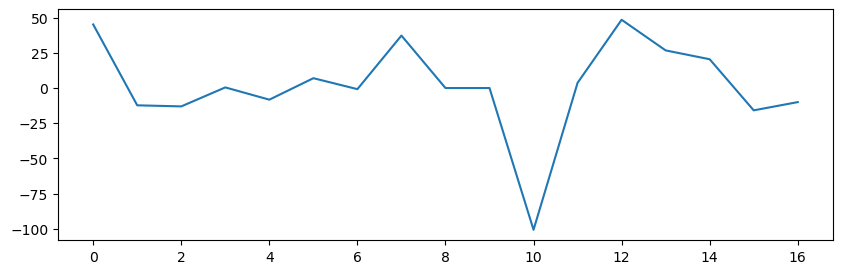

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 18/29
Found 3 similar days for inquiry 17
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2907.14, 原始成本 2925.52, (降低 18.38)
发现有效策略 strategy_2，成本 2913.23, 原始成本 2925.52, (降低 12.29)
发现有效策略 strategy_3，成本 2917.15, 原始成本 2925.52, (降低 8.37)
发现有效策略 strategy_6，成本 2920.32, 原始成本 2925.52, (降低 5.20)
发现有效策略 strategy_9，成本 2921.87, 原始成本 2925.52, (降低 3.65)
发现有效策略 strategy_10，成本 2908.05, 原始成本 2925.52, (降低 17.47)
策略生成尝试 #2 (当前有效策略: 6/20)
发现有效策略 strategy_1，成本 2909.95, 原始成本 2925.52, (降低 15.57)
发现有效策略 strategy_3，成本 2901.01, 原始成本 2925.52, (降低 24.51)
发现有效策略 strategy_6，成本 2919.64, 原始成本 2925.52, (降低 5.88)
发现有效策略 strategy_7，成本 2909.06, 原始成本 2925.52, (降低 16.46)
发现有效策略 strategy_8，成本 2908.05, 原始成本 2925.52, (降低 17.47)
发现有效策略 strategy_10，成本 2920.50, 原始成本 2925.52, (降低 5.02)
策略生成尝试 #3 (当前有效策略: 12/20)
give actual value
发现有效策略 strategy_1，成本 2907.14, 原始成本 2925.52, (降

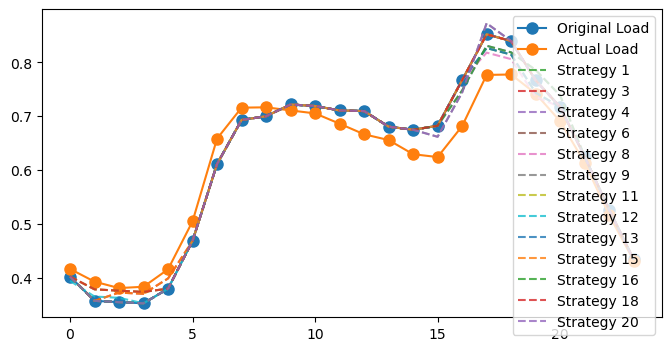

Found 1 relevant failed reflection cases for inquiry 17


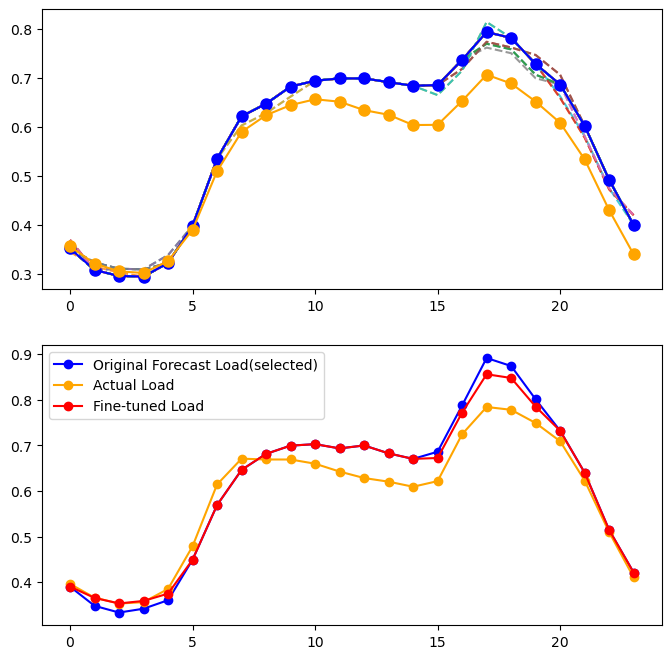

Original cost: 3068.5172119140625, Fine-tuned cost: 2993.5953913768235
2921.814296386719
2916.0801938085087


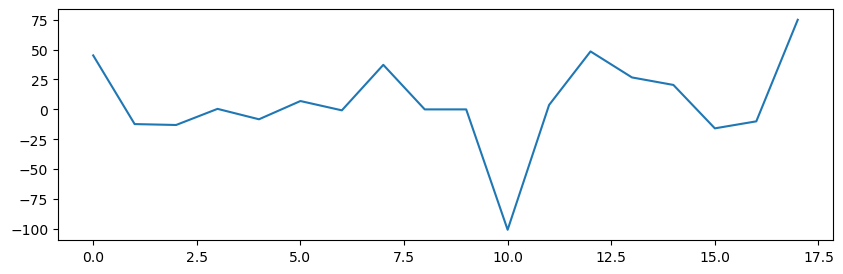

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 19/29
Found 3 similar days for inquiry 18
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2734.46, 原始成本 2746.98, (降低 12.52)
发现有效策略 strategy_3，成本 2737.08, 原始成本 2746.98, (降低 9.90)
发现有效策略 strategy_5，成本 2735.49, 原始成本 2746.98, (降低 11.49)
发现有效策略 strategy_7，成本 2745.65, 原始成本 2746.98, (降低 1.33)
策略生成尝试 #2 (当前有效策略: 4/20)
发现有效策略 strategy_3，成本 2734.46, 原始成本 2746.98, (降低 12.52)
发现有效策略 strategy_4，成本 2737.08, 原始成本 2746.98, (降低 9.90)
发现有效策略 strategy_5，成本 2735.49, 原始成本 2746.98, (降低 11.49)
发现有效策略 strategy_7，成本 2745.65, 原始成本 2746.98, (降低 1.33)
发现有效策略 strategy_10，成本 2736.92, 原始成本 2746.98, (降低 10.06)
策略生成尝试 #3 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_1，成本 2730.28, 原始成本 2746.98, (降低 16.70)
发现有效策略 strategy_2，成本 2737.03, 原始成本 2746.98, (降低 9.95)
发现有效策略 strategy_3，成本 2735.49, 原始成本 2746.98, (降低 11.49)
发现有效策略 strategy_6，成本 2733.28, 原始成本 2746.98, (降低 

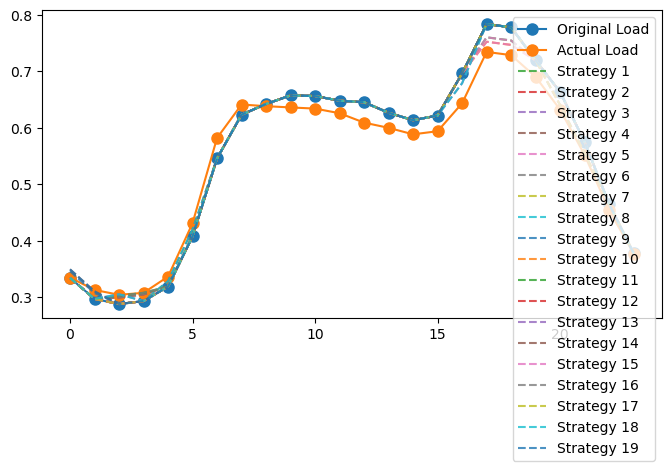

Found 1 relevant failed reflection cases for inquiry 18


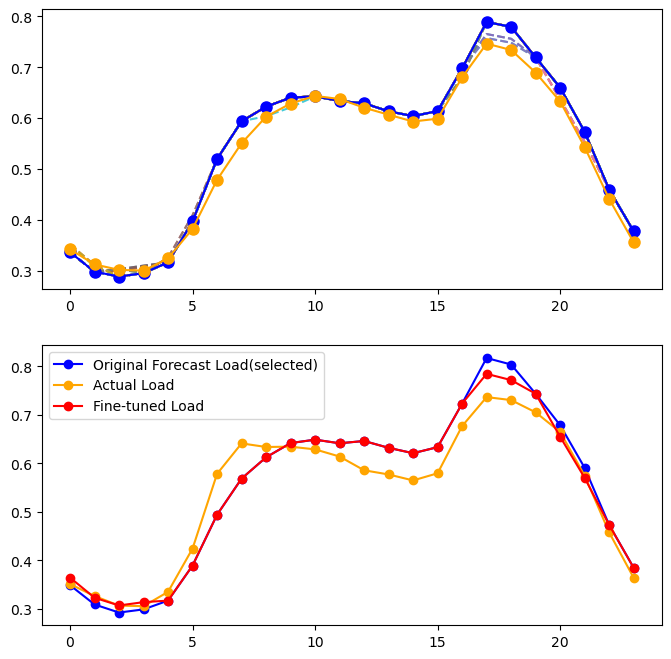

Original cost: 2977.098112792969, Fine-tuned cost: 2941.063631306973
2924.7239709344162
2917.395111571586


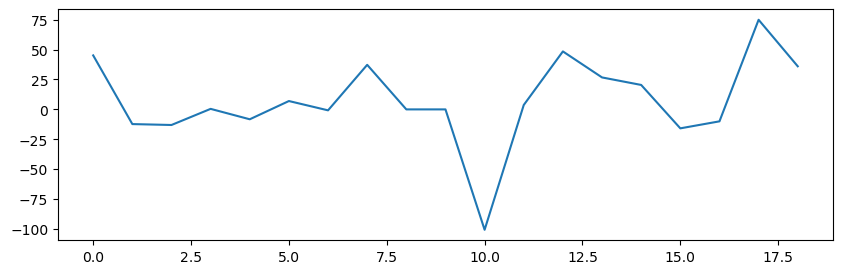

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 20/29
Found 3 similar days for inquiry 19
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2673.74, 原始成本 2685.61, (降低 11.86)
发现有效策略 strategy_4，成本 2676.48, 原始成本 2685.61, (降低 9.13)
发现有效策略 strategy_7，成本 2676.31, 原始成本 2685.61, (降低 9.30)
发现有效策略 strategy_9，成本 2678.12, 原始成本 2685.61, (降低 7.49)
策略生成尝试 #2 (当前有效策略: 4/20)
发现有效策略 strategy_1，成本 2673.74, 原始成本 2685.61, (降低 11.86)
发现有效策略 strategy_3，成本 2678.00, 原始成本 2685.61, (降低 7.60)
发现有效策略 strategy_6，成本 2676.31, 原始成本 2685.61, (降低 9.30)
发现有效策略 strategy_8，成本 2676.16, 原始成本 2685.61, (降低 9.45)
发现有效策略 strategy_10，成本 2679.21, 原始成本 2685.61, (降低 6.40)
策略生成尝试 #3 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_1，成本 2673.74, 原始成本 2685.61, (降低 11.86)
发现有效策略 strategy_2，成本 2676.16, 原始成本 2685.61, (降低 9.45)
发现有效策略 strategy_3，成本 2678.00, 原始成本 2685.61, (降低 7.60)
发现有效策略 strategy_4，成本 2676.31, 原始成本 2685.61, (降低 9.30

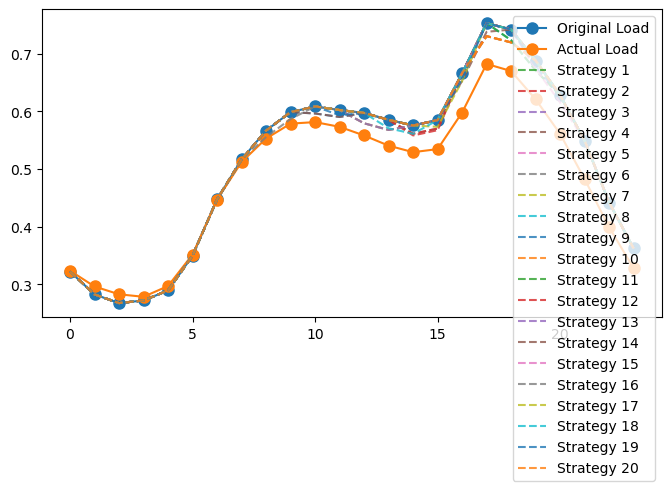

Found 1 relevant failed reflection cases for inquiry 19


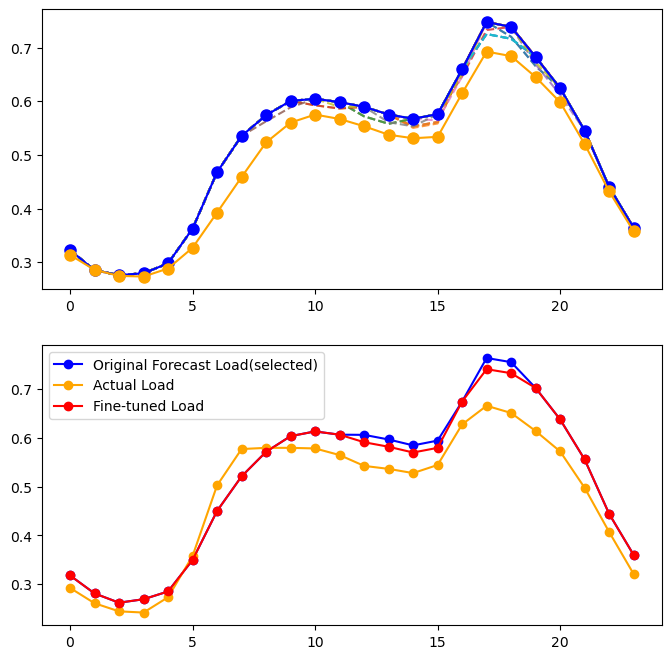

Original cost: 2828.135686523438, Fine-tuned cost: 2800.159465610284
2919.8945567138676
2911.5333292735204


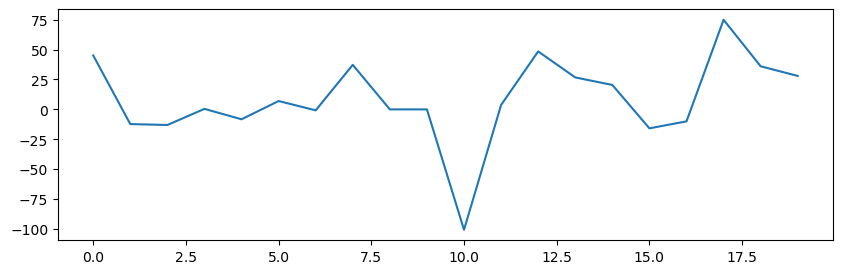

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 21/29
Found 3 similar days for inquiry 20
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2571.56, 原始成本 2573.85, (降低 2.29)
发现有效策略 strategy_8，成本 2557.00, 原始成本 2573.85, (降低 16.85)
发现有效策略 strategy_9，成本 2568.90, 原始成本 2573.85, (降低 4.95)
策略生成尝试 #2 (当前有效策略: 3/20)
发现有效策略 strategy_1，成本 2571.56, 原始成本 2573.85, (降低 2.29)
发现有效策略 strategy_5，成本 2572.46, 原始成本 2573.85, (降低 1.39)
策略生成尝试 #3 (当前有效策略: 5/20)
give actual value
发现有效策略 strategy_1，成本 2571.56, 原始成本 2573.85, (降低 2.29)
发现有效策略 strategy_5，成本 2572.46, 原始成本 2573.85, (降低 1.39)
发现有效策略 strategy_6，成本 2557.00, 原始成本 2573.85, (降低 16.85)
策略生成尝试 #4 (当前有效策略: 8/20)
give actual value
发现有效策略 strategy_1，成本 2571.56, 原始成本 2573.85, (降低 2.29)
发现有效策略 strategy_2，成本 2571.58, 原始成本 2573.85, (降低 2.27)
发现有效策略 strategy_3，成本 2557.00, 原始成本 2573.85, (降低 16.85)
发现有效策略 strategy_4，成本 2572.46, 原始成本 2573.85, (降低 1.39)
发现有效策略 str

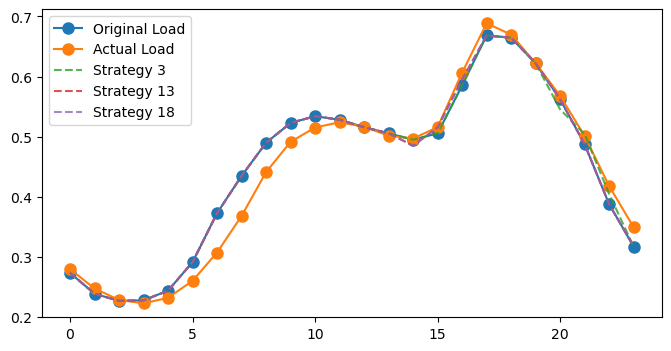

Found 1 relevant failed reflection cases for inquiry 20


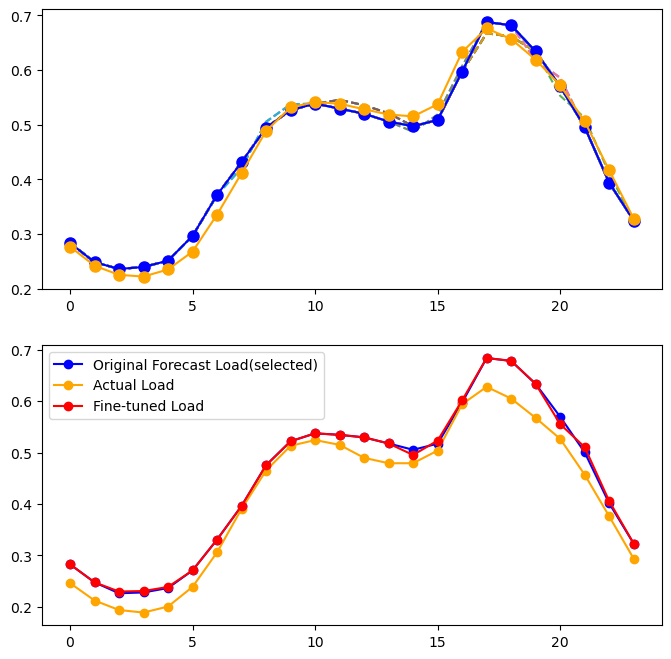

Original cost: 2520.8567573242185, Fine-tuned cost: 2522.9350832745267
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_1，成本 2509.99, 原始成本 2520.86, (降低 10.87)
策略生成尝试 #2 (当前有效策略: 1/5)
give actual value
发现有效策略 strategy_1，成本 2509.99, 原始成本 2520.86, (降低 10.87)
发现有效策略 strategy_4，成本 2516.91, 原始成本 2520.86, (降低 3.95)
发现有效策略 strategy_5，成本 2506.47, 原始成本 2520.86, (降低 14.39)
发现有效策略 strategy_6，成本 2518.62, 原始成本 2520.86, (降低 2.24)
2900.892756742932
2893.028650892616


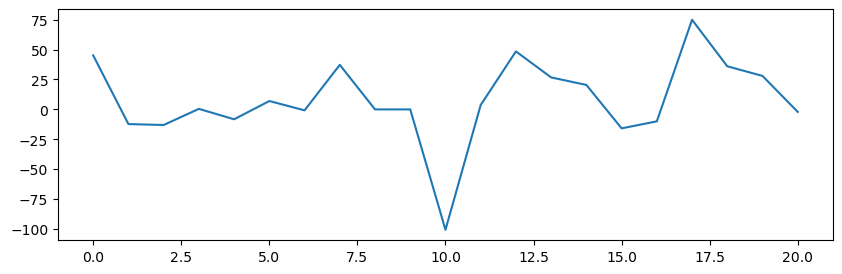

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 22/29
Found 3 similar days for inquiry 21
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2562.83, 原始成本 2573.78, (降低 10.95)
发现有效策略 strategy_3，成本 2571.36, 原始成本 2573.78, (降低 2.42)
策略生成尝试 #2 (当前有效策略: 2/20)
发现有效策略 strategy_1，成本 2562.83, 原始成本 2573.78, (降低 10.95)
发现有效策略 strategy_2，成本 2571.36, 原始成本 2573.78, (降低 2.42)
发现有效策略 strategy_4，成本 2564.76, 原始成本 2573.78, (降低 9.02)
发现有效策略 strategy_5，成本 2557.37, 原始成本 2573.78, (降低 16.41)
发现有效策略 strategy_6，成本 2571.87, 原始成本 2573.78, (降低 1.91)
发现有效策略 strategy_8，成本 2567.76, 原始成本 2573.78, (降低 6.02)
策略生成尝试 #3 (当前有效策略: 8/20)
give actual value
发现有效策略 strategy_1，成本 2562.83, 原始成本 2573.78, (降低 10.95)
发现有效策略 strategy_2，成本 2571.36, 原始成本 2573.78, (降低 2.42)
发现有效策略 strategy_3，成本 2564.76, 原始成本 2573.78, (降低 9.02)
发现有效策略 strategy_4，成本 2557.37, 原始成本 2573.78, (降低 16.41)
发现有效策略 strategy_5，成本 2571.87, 原始成本 2573.78, (降低 1.9

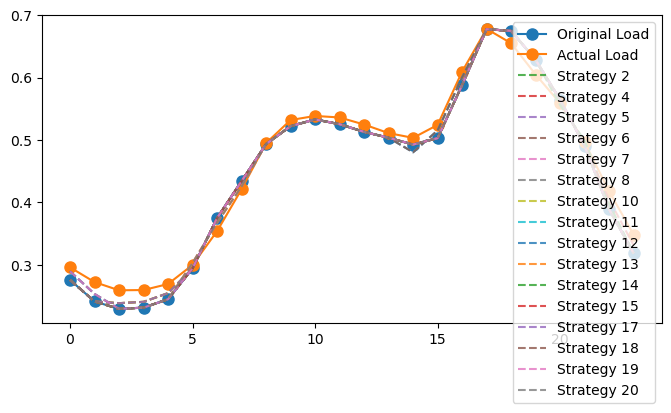

Found 1 relevant failed reflection cases for inquiry 21


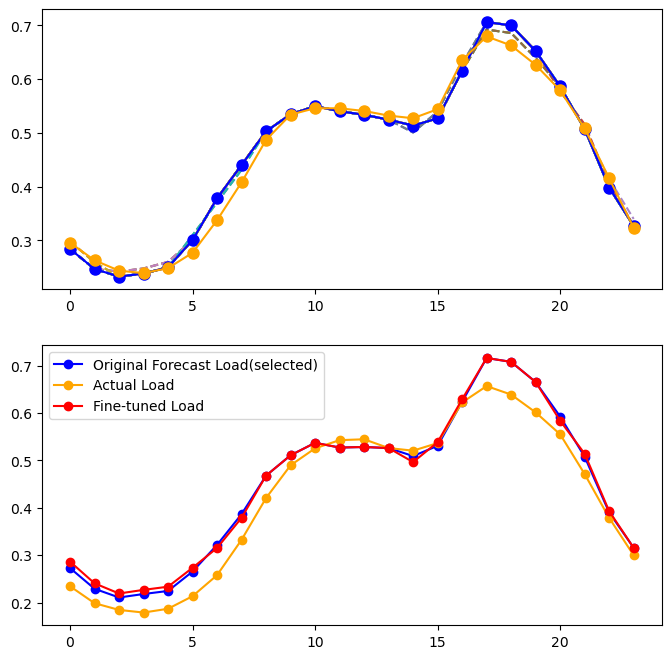

Original cost: 2559.960087402344, Fine-tuned cost: 2578.4064291266322
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_1，成本 2548.59, 原始成本 2559.96, (降低 11.37)
发现有效策略 strategy_7，成本 2557.95, 原始成本 2559.96, (降低 2.01)
策略生成尝试 #2 (当前有效策略: 2/5)
give actual value
发现有效策略 strategy_1，成本 2548.59, 原始成本 2559.96, (降低 11.37)
发现有效策略 strategy_4，成本 2556.92, 原始成本 2559.96, (降低 3.04)
发现有效策略 strategy_5，成本 2555.90, 原始成本 2559.96, (降低 4.06)
2885.3958172274506
2878.727640812344


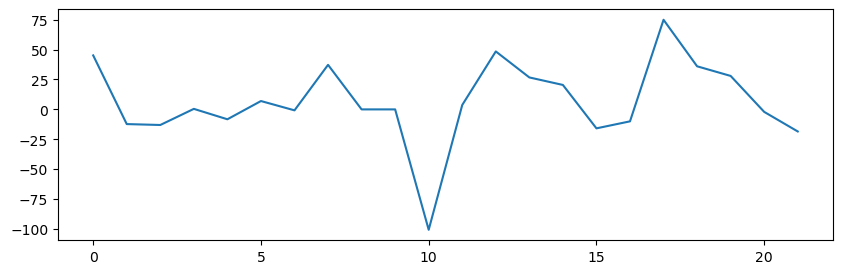

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 23/29
Found 3 similar days for inquiry 22
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2655.13, 原始成本 2660.95, (降低 5.82)
发现有效策略 strategy_6，成本 2656.67, 原始成本 2660.95, (降低 4.28)
策略生成尝试 #2 (当前有效策略: 2/20)
发现有效策略 strategy_1，成本 2655.13, 原始成本 2660.95, (降低 5.82)
发现有效策略 strategy_4，成本 2657.08, 原始成本 2660.95, (降低 3.87)
发现有效策略 strategy_6，成本 2656.67, 原始成本 2660.95, (降低 4.28)
发现有效策略 strategy_9，成本 2658.81, 原始成本 2660.95, (降低 2.14)
策略生成尝试 #3 (当前有效策略: 6/20)
give actual value
发现有效策略 strategy_1，成本 2654.75, 原始成本 2660.95, (降低 6.20)
发现有效策略 strategy_2，成本 2659.19, 原始成本 2660.95, (降低 1.76)
发现有效策略 strategy_3，成本 2656.67, 原始成本 2660.95, (降低 4.28)
发现有效策略 strategy_4，成本 2657.36, 原始成本 2660.95, (降低 3.59)
发现有效策略 strategy_5，成本 2658.63, 原始成本 2660.95, (降低 2.32)
发现有效策略 strategy_7，成本 2658.52, 原始成本 2660.95, (降低 2.43)
发现有效策略 strategy_10，成本 2659.30, 原始成本 2660.95, (降低 1.65)
策

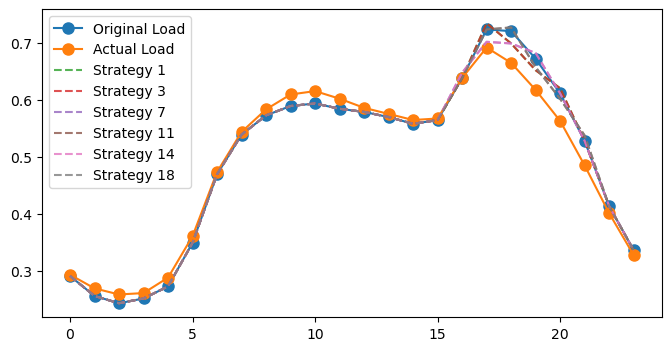

Found 1 relevant failed reflection cases for inquiry 22


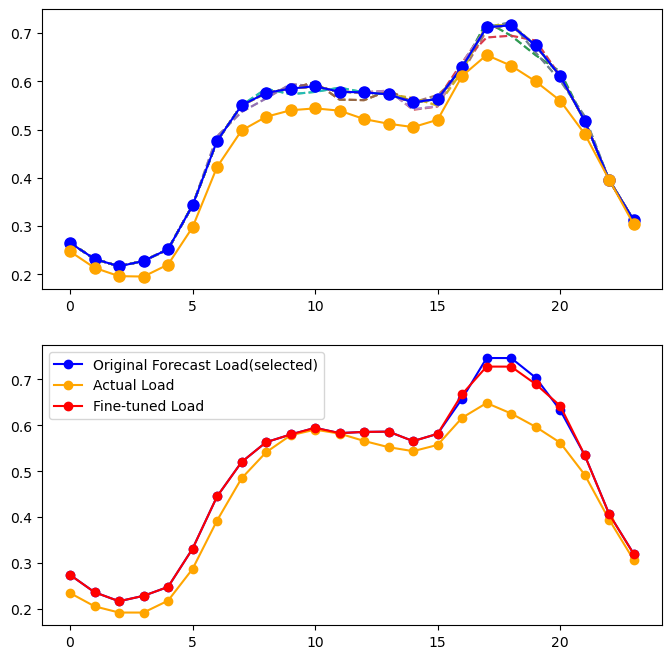

Original cost: 2667.900646484375, Fine-tuned cost: 2659.375302342969
2875.9395054560123
2869.1905826180237


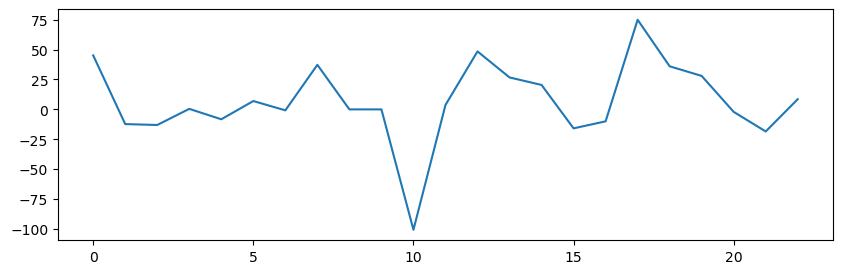

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 24/29
Found 3 similar days for inquiry 23
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2650.63, 原始成本 2669.37, (降低 18.74)
发现有效策略 strategy_5，成本 2664.66, 原始成本 2669.37, (降低 4.71)
发现有效策略 strategy_8，成本 2659.39, 原始成本 2669.37, (降低 9.97)
发现有效策略 strategy_9，成本 2664.77, 原始成本 2669.37, (降低 4.60)
发现有效策略 strategy_10，成本 2666.95, 原始成本 2669.37, (降低 2.42)
策略生成尝试 #2 (当前有效策略: 5/20)
发现有效策略 strategy_1，成本 2650.63, 原始成本 2669.37, (降低 18.74)
发现有效策略 strategy_4，成本 2658.53, 原始成本 2669.37, (降低 10.84)
发现有效策略 strategy_5，成本 2664.66, 原始成本 2669.37, (降低 4.71)
发现有效策略 strategy_8，成本 2659.39, 原始成本 2669.37, (降低 9.97)
发现有效策略 strategy_9，成本 2664.77, 原始成本 2669.37, (降低 4.60)
发现有效策略 strategy_10，成本 2666.95, 原始成本 2669.37, (降低 2.42)
策略生成尝试 #3 (当前有效策略: 11/20)
give actual value
发现有效策略 strategy_1，成本 2650.63, 原始成本 2669.37, (降低 18.74)
发现有效策略 strategy_2，成本 2664.66, 原始成本 2669.37, (降低 4

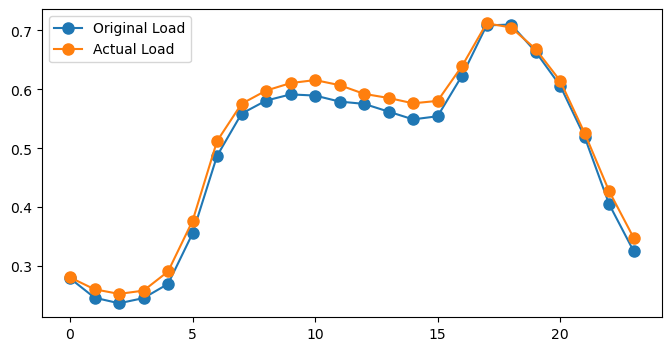

Inquiry 23: No valid strategy found, using original curve as fine-tuned result.
2874.705233520508
2868.237515800769


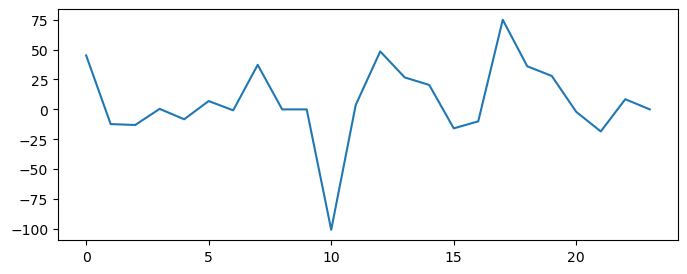

Processing inquiry 25/29
Found 3 similar days for inquiry 24
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_8，成本 2572.88, 原始成本 2577.78, (降低 4.90)
发现有效策略 strategy_10，成本 2573.32, 原始成本 2577.78, (降低 4.46)
策略生成尝试 #2 (当前有效策略: 2/20)
发现有效策略 strategy_2，成本 2574.07, 原始成本 2577.78, (降低 3.71)
发现有效策略 strategy_4，成本 2570.42, 原始成本 2577.78, (降低 7.37)
发现有效策略 strategy_8，成本 2572.88, 原始成本 2577.78, (降低 4.90)
发现有效策略 strategy_9，成本 2573.32, 原始成本 2577.78, (降低 4.46)
策略生成尝试 #3 (当前有效策略: 6/20)
give actual value
发现有效策略 strategy_4，成本 2570.42, 原始成本 2577.78, (降低 7.37)
发现有效策略 strategy_6，成本 2571.83, 原始成本 2577.78, (降低 5.95)
发现有效策略 strategy_7，成本 2575.85, 原始成本 2577.78, (降低 1.93)
策略生成尝试 #4 (当前有效策略: 9/20)
give actual value
发现有效策略 strategy_2，成本 2574.08, 原始成本 2577.78, (降低 3.70)
发现有效策略 strategy_3，成本 2570.42, 原始成本 2577.78, (降低 7.37)
发现有效策略 strategy_4，成本 2571.83, 原始成本 2577.78, (降低 5.95)
发现有效策略 strategy_5，成本 2572.88, 原始成本 2577.78, (降低 4.90)
发现有效策略 strategy_6，成本 2575.43, 原始成本 2577.78, (降低

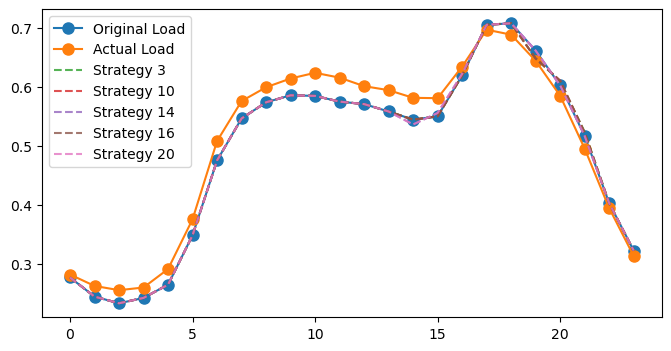

Found 1 relevant failed reflection cases for inquiry 24


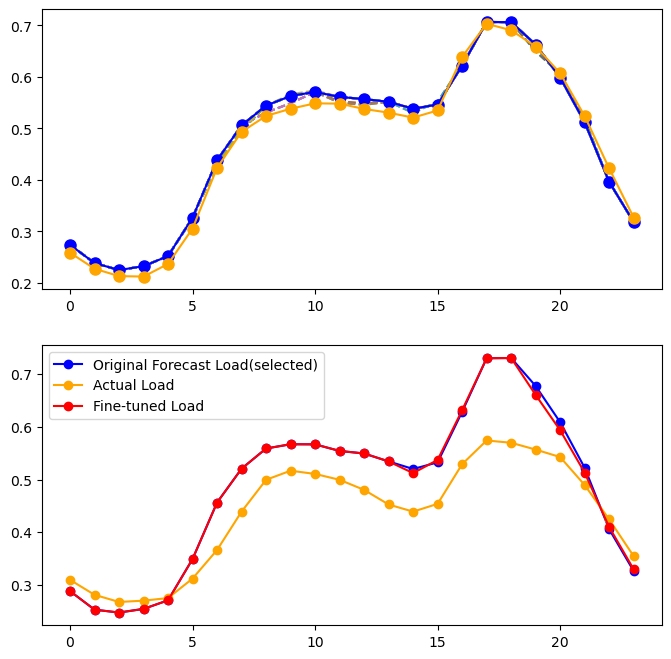

Original cost: 2825.067557128906, Fine-tuned cost: 2809.7604307734427
2872.719726464844
2865.898432399676


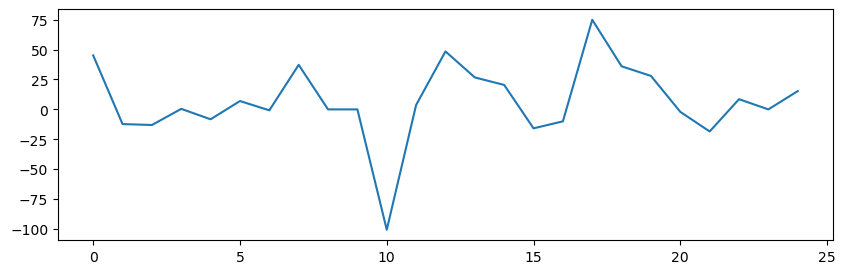

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9, 23]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 26/29
Found 3 similar days for inquiry 25
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2604.86, 原始成本 2621.43, (降低 16.56)
发现有效策略 strategy_3，成本 2611.28, 原始成本 2621.43, (降低 10.14)
发现有效策略 strategy_7，成本 2612.58, 原始成本 2621.43, (降低 8.85)
发现有效策略 strategy_8，成本 2613.75, 原始成本 2621.43, (降低 7.68)
发现有效策略 strategy_9，成本 2609.41, 原始成本 2621.43, (降低 12.02)
发现有效策略 strategy_10，成本 2608.18, 原始成本 2621.43, (降低 13.25)
策略生成尝试 #2 (当前有效策略: 6/20)
发现有效策略 strategy_1，成本 2604.86, 原始成本 2621.43, (降低 16.56)
发现有效策略 strategy_3，成本 2611.28, 原始成本 2621.43, (降低 10.14)
发现有效策略 strategy_4，成本 2616.95, 原始成本 2621.43, (降低 4.48)
发现有效策略 strategy_8，成本 2611.88, 原始成本 2621.43, (降低 9.55)
策略生成尝试 #3 (当前有效策略: 10/20)
give actual value
发现有效策略 strategy_1，成本 2607.89, 原始成本 2621.43, (降低 13.53)
发现有效策略 strategy_2，成本 2608.87, 原始成本 2621.43, (降低 12.56)
发现有效策略 strategy_4，成本 2614.02, 原始成本 2621.43

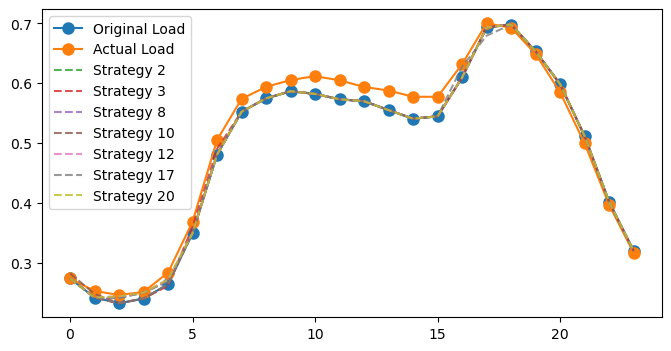

Found 1 relevant failed reflection cases for inquiry 25


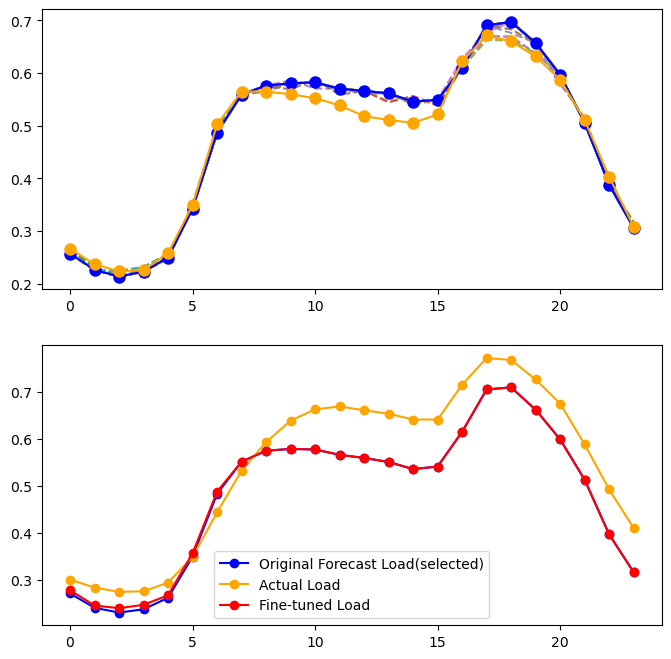

Original cost: 3709.3938129882818, Fine-tuned cost: 3687.0104062181713
2904.899499023438
2897.479662161926


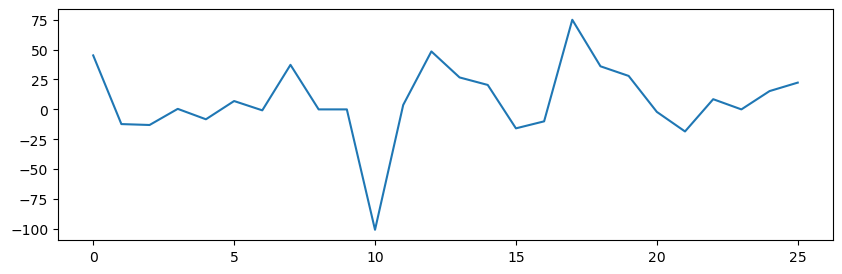

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9, 23]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 27/29
Found 3 similar days for inquiry 26
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2804.37, 原始成本 2816.96, (降低 12.59)
发现有效策略 strategy_3，成本 2802.62, 原始成本 2816.96, (降低 14.33)
发现有效策略 strategy_10，成本 2813.29, 原始成本 2816.96, (降低 3.67)
策略生成尝试 #2 (当前有效策略: 3/20)
发现有效策略 strategy_1，成本 2804.37, 原始成本 2816.96, (降低 12.59)
发现有效策略 strategy_3，成本 2802.62, 原始成本 2816.96, (降低 14.33)
发现有效策略 strategy_9，成本 2810.09, 原始成本 2816.96, (降低 6.87)
发现有效策略 strategy_10，成本 2813.29, 原始成本 2816.96, (降低 3.67)
策略生成尝试 #3 (当前有效策略: 7/20)
give actual value
发现有效策略 strategy_1，成本 2804.37, 原始成本 2816.96, (降低 12.59)
发现有效策略 strategy_3，成本 2802.62, 原始成本 2816.96, (降低 14.33)
发现有效策略 strategy_5，成本 2807.64, 原始成本 2816.96, (降低 9.31)
发现有效策略 strategy_9，成本 2812.30, 原始成本 2816.96, (降低 4.65)
发现有效策略 strategy_10，成本 2813.29, 原始成本 2816.96, (降低 3.67)
策略生成尝试 #4 (当前有效策略: 12/20)
give actual value

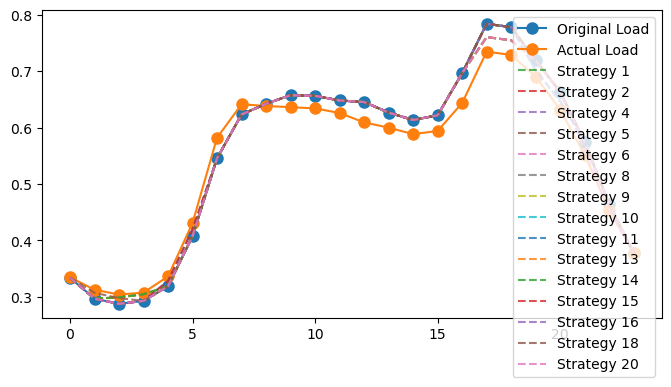

Found 1 relevant failed reflection cases for inquiry 26


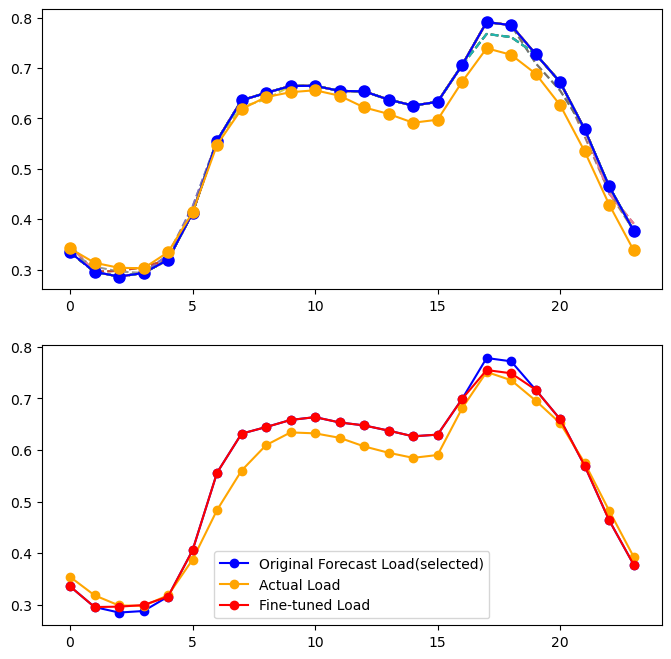

Original cost: 2837.7788227539068, Fine-tuned cost: 2810.445239851028
2902.4135480504924
2894.2561650393004


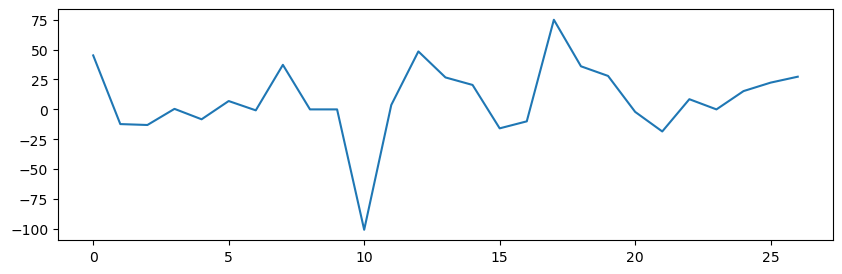

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9, 23]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 28/29
Found 3 similar days for inquiry 27
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2548.57, 原始成本 2559.97, (降低 11.39)
发现有效策略 strategy_2，成本 2557.04, 原始成本 2559.97, (降低 2.93)
发现有效策略 strategy_4，成本 2557.08, 原始成本 2559.97, (降低 2.89)
发现有效策略 strategy_5，成本 2557.36, 原始成本 2559.97, (降低 2.61)
发现有效策略 strategy_6，成本 2552.45, 原始成本 2559.97, (降低 7.52)
发现有效策略 strategy_9，成本 2556.38, 原始成本 2559.97, (降低 3.59)
发现有效策略 strategy_10，成本 2557.80, 原始成本 2559.97, (降低 2.17)
策略生成尝试 #2 (当前有效策略: 7/20)
发现有效策略 strategy_1，成本 2548.70, 原始成本 2559.97, (降低 11.26)
发现有效策略 strategy_3，成本 2557.08, 原始成本 2559.97, (降低 2.89)
发现有效策略 strategy_4，成本 2557.36, 原始成本 2559.97, (降低 2.61)
发现有效策略 strategy_5，成本 2552.45, 原始成本 2559.97, (降低 7.52)
发现有效策略 strategy_6，成本 2556.38, 原始成本 2559.97, (降低 3.59)
发现有效策略 strategy_9，成本 2557.80, 原始成本 2559.97, (降低 2.17)
发现有效策略 strategy_10，成本 2556.08, 原始成本 25

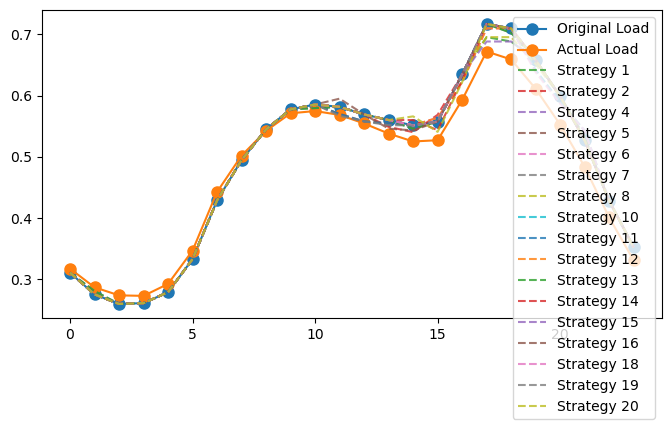

Found 1 relevant failed reflection cases for inquiry 27


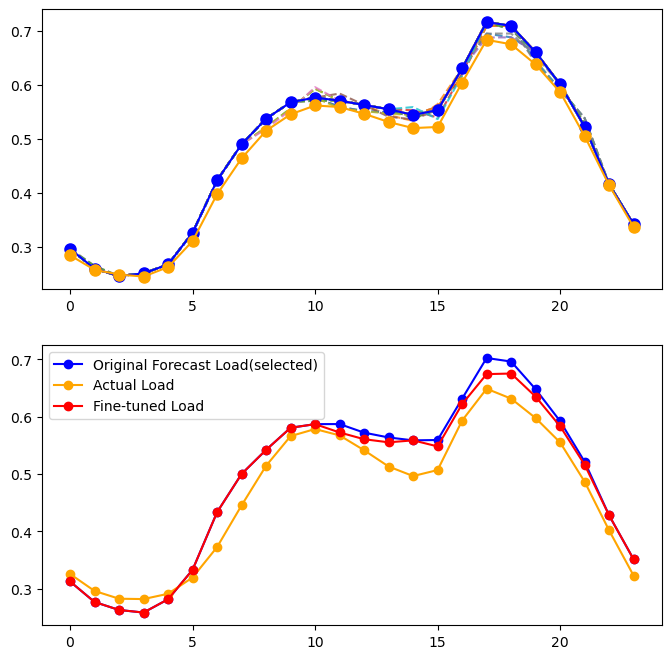

Original cost: 2692.061259765625, Fine-tuned cost: 2657.1680806449535
2894.900966326033
2885.788733453788


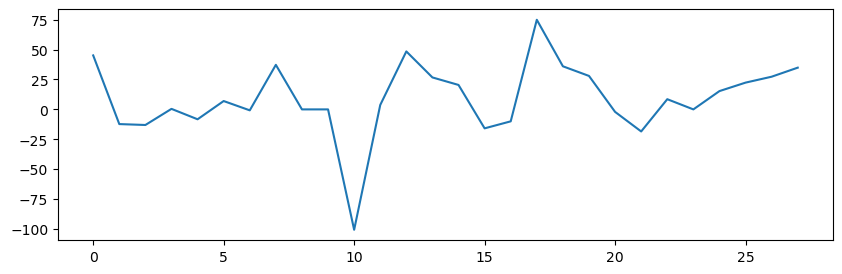

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9, 23]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []
Processing inquiry 29/29
Found 3 similar days for inquiry 28
Generating few-shot prompts based on similar days...
策略生成尝试 #1 (当前有效策略: 0/20)
发现有效策略 strategy_1，成本 2564.42, 原始成本 2573.78, (降低 9.36)
发现有效策略 strategy_3，成本 2568.14, 原始成本 2573.78, (降低 5.64)
发现有效策略 strategy_6，成本 2559.13, 原始成本 2573.78, (降低 14.65)
策略生成尝试 #2 (当前有效策略: 3/20)
发现有效策略 strategy_1，成本 2564.42, 原始成本 2573.78, (降低 9.36)
发现有效策略 strategy_3，成本 2568.14, 原始成本 2573.78, (降低 5.64)
发现有效策略 strategy_6，成本 2559.13, 原始成本 2573.78, (降低 14.65)
发现有效策略 strategy_9，成本 2571.57, 原始成本 2573.78, (降低 2.21)
发现有效策略 strategy_10，成本 2571.09, 原始成本 2573.78, (降低 2.69)
策略生成尝试 #3 (当前有效策略: 8/20)
give actual value
发现有效策略 strategy_1，成本 2562.09, 原始成本 2573.78, (降低 11.69)
发现有效策略 strategy_2，成本 2567.79, 原始成本 2573.78, (降低 5.99)
发现有效策略 strategy_3，成本 2557.37, 原始成本 2573.78, (降低 16.41)
发现有效策略 strategy_6，成本 2569.83, 原始成本 2573.78, (降低 3.95)
发现有效策略 strategy_10，成本 2569.91, 原始成本 2573.78, (降

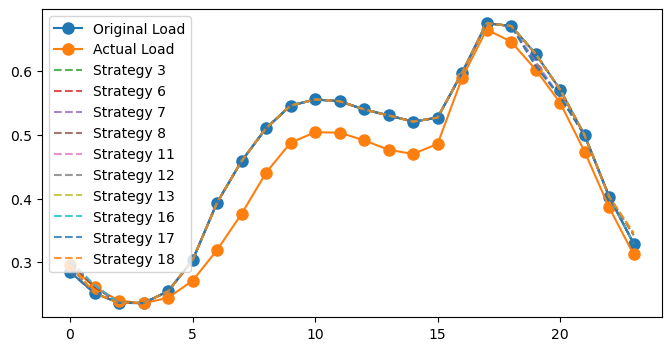

Found 1 relevant failed reflection cases for inquiry 28


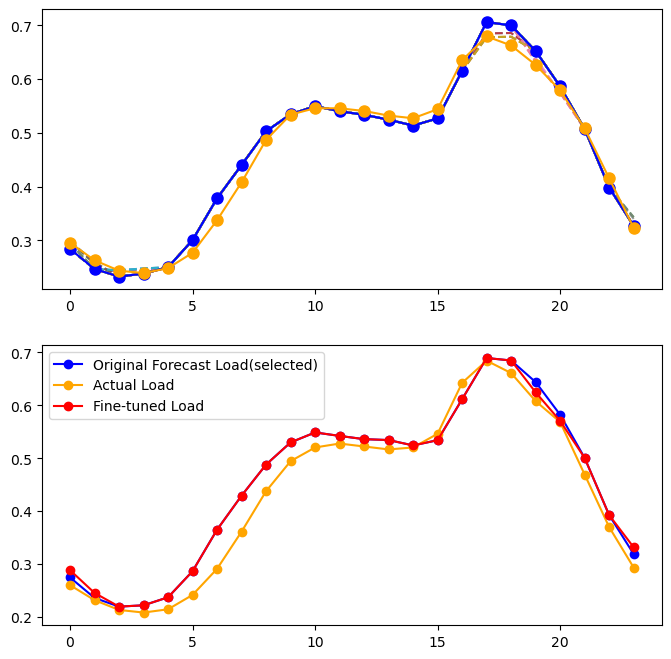

Original cost: 2546.3272666015623, Fine-tuned cost: 2547.4234078896525
策略生成尝试 #1 (当前有效策略: 0/5)
发现有效策略 strategy_5，成本 2539.37, 原始成本 2546.33, (降低 6.96)
策略生成尝试 #2 (当前有效策略: 1/5)
give actual value
发现有效策略 strategy_2，成本 2542.85, 原始成本 2546.33, (降低 3.48)
发现有效策略 strategy_4，成本 2543.58, 原始成本 2546.33, (降低 2.75)
发现有效策略 strategy_5，成本 2539.77, 原始成本 2546.33, (降低 6.55)
发现有效策略 strategy_10，成本 2543.42, 原始成本 2546.33, (降低 2.90)
2882.881183576914
2874.1209636067492


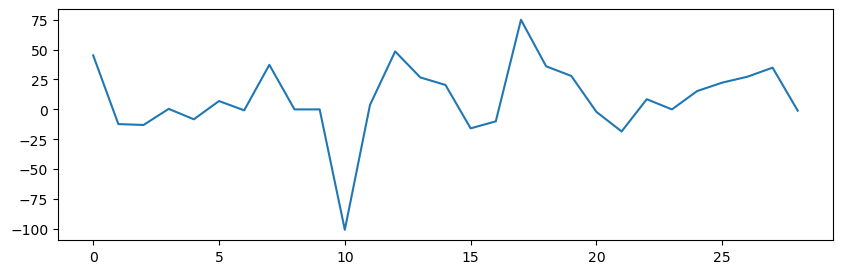

以下样本（inqure_id）未完成LLM微调，使用了原始预测曲线结果: [8, 9, 23]
以下样本（inqure_id）在验证集上未能找到有效策略，使用了原始预测曲线结果: []


In [ ]:
fine_tuned_result_given_by_LLM = {
    'selected_flag': [], 'original_load': [], 'optnet_load': [], 'fine_tuned_load': [], 
    'cost_org': [], 'cost_optnet': [], 'cost_after': [], 'actual_load': [],
    'few_shot_curves': [], 'few_shot_costs': [], 'few_shot_code': [], 
    'similar_load': [], 'similar_actual极load': [], 'strategy_code': []
}

skip_samples = []
validate_failures = []
reflection_records = []

for inqure_id in range(len(forecasts_load_test_insert)):
    print(f"Processing inquiry {inqure_id+1}/{len(forecasts_load_test_insert)}")
    data_for_inqure = {
        'load': forecasts_load_test_insert[inqure_id],
    }

    similar_days = db_train.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_load_org = np.mean([day['load'] for day in similar_days], axis=0)
    average_similar_load_actual = np.mean([day['actual_load'] for day in similar_days], axis=0)
    average_similar_load_org_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_org).reshape(1,-1))[0]
    average_similar_load_actual_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_actual).reshape(1,-1))[0]
    _, _, obj_org_similar_days = optimization_module.forward(average_similar_load_org_numpy, average_similar_load_actual_numpy)
    obj_org_similar_days = obj_org_similar_days.item()

    selected_flag = 'org'
    load_nor = data_for_inqure['load']
    average_similar_load = average_similar_load_org
    actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(actual_load_test_insert[inqure_id]).reshape(1,-1))[0]
    load_numpy_org = train_load_data.scaler_y.inverse_transform(np.array(data_for_inqure['load']).reshape(1,-1))[0]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    higher_flag = "higher" if sum(np.array(average_similar_load) - np.array(average_similar_load_actual)) > 0 else "lower"
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"
    print(f"Found {len(similar_days)} similar days for inquiry {inqure_id}")
    
    system_prompt = generate_prompt_sys(args, data_for_inqure)

    full_user_prompt = f"SYSTEM INSTRUCTIONS:\n{system_prompt}."
    full_user_prompt += f"""\n\nHint: You have two approaches to reduce cost:  

    1. Compare the actual value and forecast of the similar day, try to learn some error reduction strategies. In historical similar days, we found the forecasts were {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.  
    2. Compare the future positive and negative reserve prices.  
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.  
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.  
    """

    # Few-shot code integration
    print("Generating few-shot prompts based on similar days...")
    strategy_history, valid_strategies = few_shot_prompt_generate(args, similar_days, max_strategies=20, max_attempts=6)
    
    # Validate strategies on validation set
    selected_strategy = []
    similar_days_val = db_val.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_load_val = np.mean([day['load'] for day in similar_days_val], axis=0)
    average_similar_load_actual_val = np.mean([day['actual_load'] for day in similar_days_val], axis=0)
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(average_similar_load_val)), average_similar_load_val, markersize=8, marker='o', label='Original Load')
    plt.plot(range(len(average_similar_load_val)), average_similar_load_actual_val, markersize=8, marker='o', label='Actual Load')
    
    load_nor_val = average_similar_load_val.tolist()
    load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(load_nor_val).reshape(1,-1))[0]
    actual_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_actual_val).reshape(1,-1))[0]

    for strategy in valid_strategies:
        strategy_result = evaluate_individual_strategies(
            strategy['code'],
            load_nor_val,
            max_change_percent=0.1
        )
        selected_curve_val = strategy_result[list(strategy_result.keys())[0]]['adjusted_curve']

        fine_tune_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(selected_curve_val).reshape(1,-1))[0]
        _, _, obj_org_val = optimization_module.forward(load_val_numpy, actual_load_val_numpy)
        _, _, obj_fine_tune_val = optimization_module.forward(fine_tune_load_val_numpy, actual_load_val_numpy)

        if obj_org_val > obj_fine_tune_val:
            selected_strategy.append(strategy)
            plt.plot(range(24), selected_curve_val, label=strategy['name'], linestyle='--', alpha=0.8)
            print(f"Strategy {strategy['name']} succeeded on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (reduction {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
        else:
            print(f"Strategy {strategy['name']} failed on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (increase {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
    plt.legend()
    plt.show()

    # Skip if no valid fine-tuning strategies found
    if len(selected_strategy) == 0:
        print(f"Inquiry {inqure_id}: No valid strategy found, using original curve as fine-tuned result.")
        _, _, obj_org = optimization_module.forward(load_numpy_org, actual_load_numpy)

        fine_tuned_result_given_by_LLM['fine_tuned_load'].append(data_for_inqure['load'])
        fine_tuned_result_given_by_LLM['cost_after'].append(obj_org.item())

        fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
        fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
        fine_tuned_result_given_by_LLM['original_load'].append(data_for_inqure['load'])
        fine_tuned_result_given_by_LLM['similar_load'].append(average_similar_load.tolist())
        fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
        fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
        fine_tuned_result_given_by_LLM['few_shot_costs'].append([])
        fine_tuned_result_given_by_LLM['few_shot_curves'].append([])
        fine_tuned_result_given_by_LLM['few_shot_code'].append([])
        fine_tuned_result_given_by_LLM['strategy_code'].append('')
        skip_samples.append(inqure_id)
        # Visualization
        if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
            print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
            print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
            plt.figure(figsize=(8, 3))
            plt.plot(
                range(len(fine_tuned_result_given_by_LLM['cost_org'])),
                np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
                label='Compared to original'
            )
            plt.show()
            plt.close()
        continue

    # Build few-shot LLM prompt
    few_shot_costs = [s['final_cost'] for s in selected_strategy]
    few_shot_curves = [s['adjusted_curve'] for s in selected_strategy]
    few_shot_codes = [s['code'] for s in selected_strategy]
    history_snippet_prompt = 'Here are some previously discovered effective adjustment strategies:\n'
    for i, s in enumerate(selected_strategy):
        history_snippet_prompt += f"Good strategy {i+1} from few-shot:\n{s['code']}\n\n"
    history_snippet_prompt += f"You should ensemble these strategies as you can only output one adjustment_strategy function.\n"

    last_fail_reflections = get_fail_reflections_by_curve_distance(reflection_records, data_for_inqure['load'], max_num=1)
    print(f"Found {len(last_fail_reflections)} relevant failed reflection cases for inquiry {inqure_id}")
    fail_reflections_prompt = ""
    if last_fail_reflections:
        fail_reflections_prompt = 'You have failed in these examples and led to cost increase, avoid these patterns:\n'
        fail_reflections_prompt += "\n### Previous failed adjustment text examples (avoid these patterns):\n"
        for idx, record in enumerate(last_fail_reflections):
            fail_reflections_prompt += (
                f"Fail Case {idx + 1}:\n"
                f"- Last failed strategy:\n{remove_comments(record['strategy_code'])}\n\n"
                f"- Successful strategy:\n{(record['reflection_strategy'])}\n\n"
            )

    if args.LLM_type == 'Qwen':
        response = Generation.call(
            model="qwen-plus",
            messages=[
                {"role": "system", "content": full_user_prompt},
                {"role": "user", "content": output_require_prompt},
                {"role": "assistant", "content": history_snippet_prompt},
                {"role": "assistant", "content": fail_reflections_prompt},
            ],
            parameters={
                "temperature": 0.1,
                "result_format": "text",
                "max_tokens": 2048,
                "top_k": 10
            }
        )
        raw_text = response.output.text.strip()
        func_code = extract_pure_code(raw_text)

    elif args.LLM_type == 'ChatGPT':
        client = OpenAI(
            base_url='https://api.openai-proxy.org/v1',
            api_key=OPENAI_API_KEY
        )
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": full_user_prompt},
                {"role": "user", "content": output_require_prompt},
                {"role": "assistant", "content": history_snippet_prompt},
                {"role": "assistant", "content": fail_reflections_prompt},
            ],
            model="gpt-3.5-turbo",
            temperature=0.1,
            max_tokens=2048,
        )
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)
      
    elif args.LLM_type == 'Deepseek':
        client = OpenAI(api_key=DEEPSEEK_API_KEY,
                base_url="https://api.deepseek.com")
        response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": full_user_prompt},
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        stream=False,
        )
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)
        
    elif args.LLM_type == 'Llama':
        client = Together(api_key=LLAMA_API_KEY)
        response = client.chat.completions.create(
            model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",  # Can be replaced with other Llama versions
            messages=[
            {"role": "system", "content": full_user_prompt},
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        )
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)
        
    if selected_flag == 'org':
        selected_curve, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            data_for_inqure['load'],
            max_change_percent=0.1
        )
    else:
        selected_curve, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            data_for_inqure['fine_tuned_load'],
            max_change_percent=0.1
        )

    fine_tune_load_numpy =  train_load_data.scaler_y.inverse_transform(np.array(selected_curve).reshape(1, -1))[0]
    _, _, obj_org = optimization_module.forward(load_numpy_org, actual_load_numpy)
    _, _, obj_fine_tune = optimization_module.forward(fine_tune_load_numpy, actual_load_numpy)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    for i in valid_strategies:
        plt.plot(i['adjusted_curve'], label=i['name'], linestyle='--', alpha=0.8)
    if selected_flag == 'org':
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Original Load', color='blue')
    else:
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Optnet Load', color='green')
    plt.plot(range(24), i['actual_load'], markersize=8, marker='o', label='Actual Load', color='orange')
    # plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(range(24), data_for_inqure['load'], label='Original Forecast Load(selected)', marker='o', color='blue')
    plt.plot(range(24), actual_load_test_insert[inqure_id], label='Actual Load', marker='o', color='orange')
    plt.plot(range(24), selected_curve, label='Fine-tuned Load', marker='o', color='red')
    plt.legend()
    plt.show()
    print(f"Original cost: {obj_org.item()}, Fine-tuned cost: {obj_fine_tune.item()}")

    if selected_flag == 'org' and obj_fine_tune.item() < obj_org.item():
            reflection_strategy = "Cost reduction achieved."
            insight = f"Successfully reduced cost by {obj_org.item() - obj_fine_tune.item():.2f}."
    elif selected_flag == 'org' and obj_fine_tune.item() > obj_org.item():
        failures = [{
            "inqure_id": inqure_id,
            "load": data_for_inqure['load'],
            "actual_load": actual_load_test_insert[inqure_id],
            'fine_tuned_load': selected_curve,
            "cost_before": obj_org.item(),
            "cost_after": obj_fine_tune.item(),
            "strategy_code": strategy_code,
        }]

        reflection_strategy_history, reflection_valid_strategies = few_shot_prompt_generate(args, failures, max_strategies=5, max_attempts=3)
        reflection_strategy = f"For this failure case, consider:"
        for i in range(len(reflection_valid_strategies)):
            strategy = reflection_valid_strategies[i]
            reflection_strategy += f"Successful strategy {i} for failure case:\n{remove_comments(strategy['code'])}\n"

    reflection_records.append({
        "inquiry_id": inqure_id,
        "original_load": data_for_inqure['load'],
        "actual_load": actual_load_test_insert[inqure_id],
        "fine_tuned_load": selected_curve,
        "cost_before": obj_org.item(),
        "cost_after": obj_fine_tune.item(),
        "strategy_code": strategy_code,
        "reflection_strategy": reflection_strategy,
        "similar_day_comparison": f"Similar days showed forecast was {higher_flag} than actual"
    })
    reflection_records = reflection_records[-10:]  # Keep only last 10 records

    fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
    fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
    fine_tuned_result_given_by_LLM['original_load'].append(data_for_inqure['load'])
    fine_tuned_result_given_by_LLM['fine_tuned_load'].append(selected_curve)
    fine_tuned_result_given_by_LLM['cost_after'].append(obj_fine_tune.item())
    fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
    fine_tuned_result_given_by_LLM['similar_load'].append(average_similar_load.tolist())
    fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
    fine_tuned_result_given_by_LLM['few_shot_costs'].append(few_shot_costs)
    fine_tuned_result_given_by_LLM['few_shot_curves'].append(few_shot_curves)
    fine_tuned_result_given_by_LLM['few_shot_code'].append(few_shot_codes)
    fine_tuned_result_given_by_LLM['strategy_code'].append(strategy_code)

    if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
        print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
        print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
        plt.figure(figsize=(10, 3))
        plt.plot(
            range(len(fine_tuned_result_given_by_LLM['cost_org'])),
            np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
            label='Compared to original'
        )
        plt.show()
        plt.close()

    print(f"The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: {skip_samples}")
    print(f"The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: {validate_failures}")

    with open('../Result/NN+MILP/'+args.LLM_type+'.pkl', 'wb') as f:
        pickle.dump(fine_tuned_result_given_by_LLM, f)

### result

In [16]:
# print(fine_tuned_result_given_by_LLM['cost_org'])
# print(fine_tuned_result_given_by_LLM['cost_optnet'])
# print(fine_tuned_result_given_by_LLM['cost_after'])
print(np.mean(cost_list_ideal))
print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))

2526.3265333333334
2882.881183576914
2874.1209636067492
